In [1]:
# ============================================================
# HAP Model Pipeline: High-Alert Probability (Failure Prediction)
# ============================================================
# Business Context: Predict semiconductor manufacturing failures (SECOM dataset)
# to enable early intervention before wafers reach customers.
#
# Key Challenge: Highly imbalanced data (~93% pass, 7% fail)
# Strategy: Optimize recall (catch failures) while managing alert rate (inspection capacity)
#
# Pipeline: EDA → Feature Engineering → Model Selection → Threshold Tuning → Deployment
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load SECOM dataset
df = pd.read_csv("uci-secom.csv")

print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (1567, 592)


Time        0        1          2          3       4      5  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

          6       7       8  ...       581     582     583     584      585  \
0   97.6133  0.1242  1.5005  ...       NaN  0.5005  0.0118  0.0035   2.3630   
1  102.3433  0.1247  1.4966  ...  208.2045  0.5019  0.0223  0.0055   4.4447   
2   95.4878  0.1241  1.4436  ...   82.8602  0.4958  0.0157  0.0039   3.1745   
3  104.2367  0.1217  1.4882  ...   73.8432  0.4990  0.0103  0.0025   2.0544   
4  100.3967  0.1235  1.5031  ...       NaN  0.4800  0.4766  0.1045  99.3032   

      586     587     588       589  Pass/Fail  
0     NaN     NaN     NaN       NaN         -1  
1  0.0096  0.0201  0.0060  208.2045         -1  
2  0.0584  0.0484  0.0148   82.8602          1  
3  0.0202  0.0149  0.0044   73.8432         -1  
4  0.0202  0.0149  0.0044   73.8432         -1  

[5 rows x 592 columns]

In [3]:
# ============================================================
# Visualization Setup — Consistent Presentation-Quality Style
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set Seaborn theme with viridis palette
sns.set_theme(style="whitegrid", palette="viridis")
sns.set_palette("viridis")

# Matplotlib defaults for professional appearance
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'font.family': 'sans-serif',
})

print("✓ Visualization theme configured (viridis palette)")


✓ Visualization theme configured (viridis palette)


In [4]:
# ============================================================
# Utility Functions — Reusable Production-Grade Code
# ============================================================

import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_score, recall_score, f1_score
)

def compute_classification_metrics(y_true, y_prob, threshold=0.5):
    """
    Compute comprehensive classification metrics.
    """
    y_pred = (y_prob >= threshold).astype(int)
    
    return {
        "pr_auc": average_precision_score(y_true, y_prob),
        "roc_auc": roc_auc_score(y_true, y_prob),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "alert_rate": float(y_pred.mean()),
    }

def find_optimal_threshold(y_true, y_prob, beta=2.0, min_precision=None, n_grid=300):
    """
    Find threshold that maximizes F_beta score.
    """
    quantiles = np.linspace(0.0, 1.0, n_grid)
    threshold_candidates = np.unique(np.quantile(y_prob, quantiles))
    
    best = {"threshold": 0.5, "precision": 0.0, "recall": 0.0, "f_beta": 0.0}
    
    for thr in threshold_candidates:
        y_pred = (y_prob >= thr).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        
        if (min_precision is not None) and (p < min_precision):
            continue
        
        if (p + r) > 0:
            f_beta = (1 + beta**2) * (p * r) / (beta**2 * p + r)
        else:
            f_beta = 0.0
        
        if f_beta > best["f_beta"]:
            best = {
                "threshold": float(thr),
                "precision": float(p),
                "recall": float(r),
                "f_beta": float(f_beta)
            }
    
    return best

print("✓ Utility functions loaded")


✓ Utility functions loaded


In [5]:
# Missingness per feature
missing_pct = df.isnull().mean().sort_values(ascending=False)

missing_df = pd.DataFrame({
    "missing_pct": missing_pct,
    "missing_count": df.isnull().sum()
})

missing_df.head(10)


missing_pct  missing_count
0       0.003829              6
1       0.004467              7
10      0.001276              2
100     0.003829              6
101     0.003829              6
102     0.003829              6
103     0.001276              2
104     0.001276              2
105     0.003829              6
106     0.003829              6

  → Saved to results/plot_cell_5.png


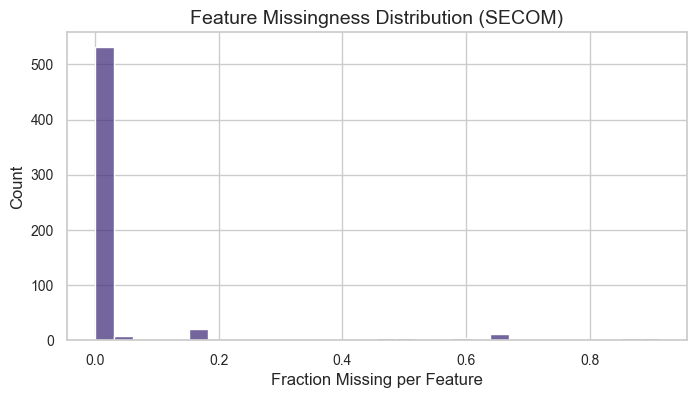

In [6]:
plt.figure(figsize=(8, 4))
sns.histplot(missing_pct, bins=30)
plt.xlabel("Fraction Missing per Feature")
plt.title("Feature Missingness Distribution (SECOM)")
plt.savefig('results/plot_cell_5.png', dpi=300, bbox_inches='tight')
print('  → Saved to results/plot_cell_5.png')
plt.show()


In [7]:
# Fraction of missing sensors per wafer
df["row_missing_pct"] = df.isnull().mean(axis=1)

# Optional: count version (sometimes easier to reason about)
df["row_missing_count"] = df.isnull().sum(axis=1)


In [8]:
df.groupby("Pass/Fail")["row_missing_pct"].describe()


count      mean       std       min       25%       50%       75%  \
Pass/Fail                                                                       
-1         1463.0  0.045379  0.022956  0.006757  0.033784  0.040541  0.054054   
 1          104.0  0.043009  0.016686  0.013514  0.033784  0.040541  0.047297   

                max  
Pass/Fail            
-1         0.256757  
 1         0.108108

In [9]:
df["missing_bin"] = pd.qcut(
    df["row_missing_pct"],
    q=5,
    duplicates="drop"
)

fail_rate_by_bin = (
    df.groupby("missing_bin")["Pass/Fail"]
    .apply(lambda x: (x == 1).mean())
)

fail_rate_by_bin


missing_bin
(0.00576, 0.027]    0.052486
(0.027, 0.0405]     0.096774
(0.0405, 0.0473]    0.063670
(0.0473, 0.0608]    0.034884
(0.0608, 0.257]     0.065116
Name: Pass/Fail, dtype: float64

In [10]:
pass_missing = df.loc[df["Pass/Fail"] == -1, "row_missing_pct"]
fail_missing = df.loc[df["Pass/Fail"] == 1, "row_missing_pct"]

pass_missing.mean(), fail_missing.mean()


(np.float64(0.045379496037390776), np.float64(0.043009355509355515))

“After analyzing missingness patterns, I found no strong monotonic relationship between row-level missingness and failure, suggesting missing values are not a dominant leakage signal. As a result, rows were retained. Features with extreme missingness were removed due to insufficient data support. For remaining sensors, median imputation was applied using training data statistics, and missingness indicators were added to allow models to capture potential interaction effects without overstating their importance

Target distribution:


count  percent
pass (0)   1463    93.36
fail (1)    104     6.64

  → Saved to results/eda_02_target_distribution.png


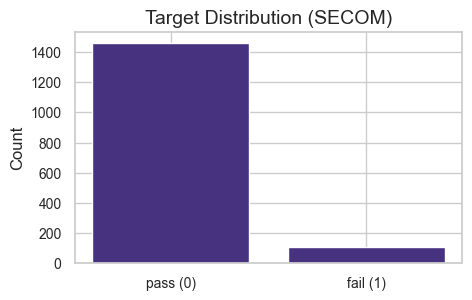

Fail rate: 0.066


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TARGET_COL = "Pass/Fail"   # adjust if needed

# 1) Convert {-1, 1} -> {0, 1} where 1 = fail
df = df.copy()
df["y"] = (df[TARGET_COL] == 1).astype(int)

# 2) Target distribution (counts + %)
dist = df["y"].value_counts().sort_index().to_frame("count")
dist.index = ["pass (0)", "fail (1)"]
dist["percent"] = (dist["count"] / dist["count"].sum() * 100).round(2)

print("Target distribution:")
display(dist)

# Optional quick plot
plt.figure(figsize=(5, 3))
plt.bar(dist.index, dist["count"])
plt.title("Target Distribution (SECOM)")
plt.ylabel("Count")
plt.savefig('results/eda_02_target_distribution.png', dpi=300, bbox_inches='tight')
print('  → Saved to results/eda_02_target_distribution.png')
plt.show()

print(f"Fail rate: {df['y'].mean():.3f}")


In [12]:
# =========================================
# SECOM: split + missing-value handling + feature pruning
# Train-only fit, apply to holdout (interview-ready)
# =========================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

# -----------------------------
# 0) Columns
# -----------------------------
TARGET_RAW = "Pass/Fail"   # original SECOM label column (-1 pass, +1 fail)
TIME_COL   = "Time"        # optional; keep separate (do not use as sensor feature)

# -----------------------------
# 1) Target cleanup: map {-1, +1} -> {0, 1}
# -----------------------------
# 0 = pass, 1 = fail
df_work = df.copy()
df_work["y"] = (df_work[TARGET_RAW] == 1).astype(int)

# -----------------------------
# 2) Separate X / y, keep Time separate
# -----------------------------
y = df_work["y"].copy()
X = df_work.drop(columns=[TARGET_RAW, "y"], errors="ignore")

time_series = None
if TIME_COL in X.columns:
    time_series = X[TIME_COL].copy()
    X = X.drop(columns=[TIME_COL])

# Force numeric for sensor columns (coerce bad values to NaN)
X = X.apply(pd.to_numeric, errors="coerce")

# -----------------------------
# 3) Stratified train/holdout split (handles class imbalance)
# -----------------------------
X_train_raw, X_holdout_raw, y_train, y_holdout = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train:", X_train_raw.shape, "Holdout:", X_holdout_raw.shape)
print("Train fail rate:", y_train.mean().round(4))
print("Holdout fail rate:", y_holdout.mean().round(4))

# -----------------------------
# 4) Missingness diagnostics (train-only)
# -----------------------------
train_row_missing_pct = X_train_raw.isnull().mean(axis=1)
hold_row_missing_pct  = X_holdout_raw.isnull().mean(axis=1)

feat_missing_pct = X_train_raw.isnull().mean(axis=0).sort_values(ascending=False)

# -----------------------------
# 5) Drop high-missing features (train-only decision)
# -----------------------------
HIGH_MISSING_THRESH = 0.50
high_missing_cols = feat_missing_pct[feat_missing_pct > HIGH_MISSING_THRESH].index.tolist()
print(f"Dropping {len(high_missing_cols)} features with > {HIGH_MISSING_THRESH:.0%} missingness")

X_train_1 = X_train_raw.drop(columns=high_missing_cols, errors="ignore")
X_hold_1  = X_holdout_raw.drop(columns=high_missing_cols, errors="ignore")

# -----------------------------
# 6) Missingness indicators (for remaining features)
# -----------------------------
missing_ind_train = X_train_1.isnull().astype(int).add_suffix("_missing")
missing_ind_hold  = X_hold_1.isnull().astype(int).add_suffix("_missing")

# -----------------------------
# 7) Median imputation (fit on train only)
# -----------------------------
train_medians = X_train_1.median(axis=0, skipna=True)

X_train_2 = X_train_1.fillna(train_medians)
X_hold_2  = X_hold_1.fillna(train_medians)

# -----------------------------
# 8) Drop constant / near-zero variance features (train-only fit)
# -----------------------------
VAR_THRESH = 0.0  # constants only; try 1e-6 later if needed
vt = VarianceThreshold(threshold=VAR_THRESH)
vt.fit(X_train_2)

keep_var_cols = X_train_2.columns[vt.get_support()].tolist()
X_train_3 = X_train_2[keep_var_cols].copy()
X_hold_3  = X_hold_2[keep_var_cols].copy()

print(f"Kept {len(keep_var_cols)} features after variance filter (dropped {X_train_2.shape[1]-len(keep_var_cols)})")

# -----------------------------
# 9) Correlation pruning (train-only decision)
# -----------------------------
CORR_THRESH = 0.95
corr = X_train_3.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

to_drop_corr = [col for col in upper.columns if any(upper[col] > CORR_THRESH)]
print(f"Dropping {len(to_drop_corr)} features with |corr| > {CORR_THRESH}")

X_train_4 = X_train_3.drop(columns=to_drop_corr, errors="ignore")
X_hold_4  = X_hold_3.drop(columns=to_drop_corr, errors="ignore")

# -----------------------------
# 10) Add row-level missingness feature + combine indicators
# -----------------------------
X_train_4["row_missing_pct"] = train_row_missing_pct.values
X_hold_4["row_missing_pct"]  = hold_row_missing_pct.values

X_train_final = pd.concat(
    [X_train_4.reset_index(drop=True), missing_ind_train.reset_index(drop=True)],
    axis=1
)
X_hold_final = pd.concat(
    [X_hold_4.reset_index(drop=True), missing_ind_hold.reset_index(drop=True)],
    axis=1
)

print("\nFinal shapes:")
print("X_train_final:", X_train_final.shape)
print("X_hold_final :", X_hold_final.shape)

# Sanity checks
assert list(X_train_final.columns) == list(X_hold_final.columns)

# Outputs ready for modeling:
# - X_train_final, y_train
# - X_hold_final,  y_holdout
# - time_series (optional, for monitoring/time drift narratives)


Train: (1253, 593) Holdout: (314, 593)
Train fail rate: 0.0662
Holdout fail rate: 0.0669
Dropping 25 features with > 50% missingness
Kept 452 features after variance filter (dropped 116)
Dropping 180 features with |corr| > 0.95

Final shapes:
X_train_final: (1253, 840)
X_hold_final : (314, 840)


In [13]:
import numpy as np
import pandas as pd

def summarize_missingness_signal(X, y, row_col="row_missing_pct", n_bins=5):
    tmp = pd.DataFrame({
        "y": y.values if hasattr(y, "values") else np.array(y),
        row_col: X[row_col].values
    })
    tmp["missing_bin"] = pd.qcut(tmp[row_col], q=n_bins, duplicates="drop")
    out = tmp.groupby("missing_bin")["y"].agg(["count", "mean"]).rename(columns={"mean":"fail_rate"})
    out["fail_rate_pct"] = (100*out["fail_rate"]).round(2)
    return out

missing_signal_table = summarize_missingness_signal(X_train_final, y_train, row_col="row_missing_pct", n_bins=5)
missing_signal_table


count  fail_rate  fail_rate_pct
missing_bin                                       
(0.00743, 0.0287]    276   0.057971           5.80
(0.0287, 0.0422]     377   0.098143           9.81
(0.0422, 0.0489]     219   0.059361           5.94
(0.0489, 0.0624]     205   0.034146           3.41
(0.0624, 0.258]      176   0.056818           5.68

In [14]:
import numpy as np
import pandas as pd

def summarize_missingness_signal(X, y, row_col="row_missing_pct", n_bins=5):
    tmp = pd.DataFrame({
        "y": y.values if hasattr(y, "values") else np.array(y),
        row_col: X[row_col].values
    })
    tmp["missing_bin"] = pd.qcut(tmp[row_col], q=n_bins, duplicates="drop")
    out = tmp.groupby("missing_bin")["y"].agg(["count", "mean"]).rename(columns={"mean":"fail_rate"})
    out["fail_rate_pct"] = (100*out["fail_rate"]).round(2)
    return out

missing_signal_table = summarize_missingness_signal(X_train_final, y_train, row_col="row_missing_pct", n_bins=5)
missing_signal_table


count  fail_rate  fail_rate_pct
missing_bin                                       
(0.00743, 0.0287]    276   0.057971           5.80
(0.0287, 0.0422]     377   0.098143           9.81
(0.0422, 0.0489]     219   0.059361           5.94
(0.0489, 0.0624]     205   0.034146           3.41
(0.0624, 0.258]      176   0.056818           5.68

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

missing_cols = [c for c in X_train_final.columns if c.endswith("_missing")]
missing_only_cols = ["row_missing_pct"] + missing_cols

pipe_missing = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # sparse-safe behavior, even though this is dense
    ("lr", LogisticRegression(max_iter=3000, class_weight="balanced", n_jobs=None))
])

pipe_missing.fit(X_train_final[missing_only_cols], y_train)

coefs = pipe_missing.named_steps["lr"].coef_.ravel()
coef_df = pd.DataFrame({"feature": missing_only_cols, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False).head(20)


feature      coef  abs_coef
0    row_missing_pct -0.375265  0.375265
214      219_missing -0.144533  0.144533
346      357_missing -0.144533  0.144533
476      491_missing -0.144533  0.144533
85        84_missing -0.144533  0.144533
42        41_missing -0.118442  0.118442
173      178_missing -0.118442  0.118442
434      449_missing -0.118442  0.118442
303      314_missing -0.118442  0.118442
435      450_missing -0.118442  0.118442
302      313_missing -0.118442  0.118442
41        40_missing -0.118442  0.118442
133      136_missing -0.096820  0.096820
1          0_missing -0.096820  0.096820
262      271_missing -0.096820  0.096820
394      409_missing -0.096820  0.096820
395      410_missing -0.093967  0.093967
2          1_missing -0.093967  0.093967
263      272_missing -0.093967  0.093967
134      137_missing -0.093967  0.093967

In [16]:
TOP_K_MISSING_FLAGS = 30  # tune: 0, 10, 30, 50

top_missing_flags = (
    coef_df[coef_df["feature"].str.endswith("_missing")]
    .sort_values("abs_coef", ascending=False)
    .head(TOP_K_MISSING_FLAGS)["feature"]
    .tolist()
)

# Feature set A: everything (current)
X_train_all = X_train_final.copy()

# Feature set B: numeric sensors + row_missing_pct + top missing flags only
sensor_cols = [c for c in X_train_final.columns if (not c.endswith("_missing")) and (c != "row_missing_pct")]
keep_cols_trim = sensor_cols + ["row_missing_pct"] + top_missing_flags

X_train_trim = X_train_final[keep_cols_trim].copy()

print("All features:", X_train_all.shape[1])
print("Trimmed features:", X_train_trim.shape[1])
print("Kept missing flags:", len(top_missing_flags))


All features: 840
Trimmed features: 302
Kept missing flags: 30


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TARGET_RAW = "Pass/Fail"
TIME_COL = "Time"

# y already created as 0/1
# y = (df[TARGET_RAW] == 1).astype(int)

# Sensor columns: numeric feature columns excluding Time and labels
sensor_cols = [c for c in df.columns if c not in [TARGET_RAW, "y", TIME_COL]]

# Force numeric sensors
X_all = df[sensor_cols].apply(pd.to_numeric, errors="coerce")

# Global missingness + basic stats
missing_pct = X_all.isna().mean().sort_values(ascending=False)
stds = X_all.std(numeric_only=True)
skew = X_all.skew(numeric_only=True)

n_const = (stds.fillna(0) == 0).sum()

print("Rows:", df.shape[0], "Sensor cols:", len(sensor_cols))
print("Fail rate:", df["y"].mean().round(4))
print("Constant features (std=0):", int(n_const))
print("Top missingness features:\n", missing_pct.head(10))


Rows: 1567 Sensor cols: 593
Fail rate: 0.0664
Constant features (std=0): 117
Top missingness features:
 missing_bin    1.000000
293            0.911934
158            0.911934
157            0.911934
292            0.911934
492            0.855775
358            0.855775
220            0.855775
85             0.855775
111            0.649649
dtype: float64


In [18]:
def summarize_features(X: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame(index=X.columns)
    out["missing_pct"] = X.isna().mean()
    out["mean"] = X.mean(numeric_only=True)
    out["std"] = X.std(numeric_only=True)
    out["min"] = X.min(numeric_only=True)
    out["p01"] = X.quantile(0.01, numeric_only=True)
    out["p50"] = X.quantile(0.50, numeric_only=True)
    out["p99"] = X.quantile(0.99, numeric_only=True)
    out["max"] = X.max(numeric_only=True)
    out["skew"] = X.skew(numeric_only=True)
    out["zero_frac"] = (X.fillna(0) == 0).mean()
    out["n_unique"] = X.nunique(dropna=True)
    return out.sort_values(["missing_pct", "std"], ascending=[False, False])

eda_summary = summarize_features(X_all)

display(eda_summary.head(15))          # most missing + high variance
display(eda_summary.sort_values("skew", ascending=False).head(15))  # most skewed
display(eda_summary.sort_values("std", ascending=False).head(15))   # widest spread


missing_pct         mean         std       min         p01  \
missing_bin     1.000000          NaN         NaN       NaN         NaN   
158             0.911934  1039.650738  406.848810  234.0996  338.484785   
293             0.911934   335.551157  137.692483   82.3233  109.226981   
157             0.911934     0.047104    0.039538    0.0118    0.016237   
292             0.911934     0.014487    0.011494    0.0041    0.005811   
492             0.855775     8.170943    1.759262    4.8882    5.484475   
85              0.855775     0.112783    0.002928    0.1053    0.106125   
220             0.855775     0.009213    0.001989    0.0057    0.006225   
358             0.855775     0.002443    0.000395    0.0017    0.001800   
516             0.649649     0.678898   10.783880    0.0287    0.051280   
246             0.649649     4.148742   10.045084    1.1022    1.540268   
517             0.649649     1.738902    4.890663    0.2880    0.488900   
518             0.649649     1.806273    4.715894    0.4674    0.659372   
245             0.649649     1.729723    4.335614    0.2914    0.497344   
384             0.649649     1.285448    3.168427    0.3383    0.521856   

                    p50          p99        max       skew  zero_frac  \
missing_bin         NaN          NaN        NaN        NaN   1.000000   
158          1020.30005  2194.023874  2505.2998   0.757013   0.911934   
293           317.86710   748.098942   879.2260   1.011483   0.911934   
157             0.03545     0.217532     0.2876   3.460228   0.911934   
292             0.01100     0.064939     0.0831   3.426849   0.911934   
492             8.00895    12.673475    21.0443   2.035554   0.855775   
85              0.11355     0.117725     0.1184  -0.530001   0.855775   
220             0.00895     0.013825     0.0240   2.101907   0.855775   
358             0.00240     0.003400     0.0047   1.116095   0.855775   
516             0.17470     0.825672   252.8604  23.421642   0.649649   
246             3.67300     7.297376   237.1837  22.866523   0.649649   
517             1.15430     5.975020   113.2758  21.747968   0.649649   
518             1.58910     3.129784   111.3495  22.954084   0.649649   
245             1.18510     5.940548    99.9022  21.298094   0.649649   
384             1.10630     2.306144    74.8445  22.917695   0.649649   

             n_unique  
missing_bin         0  
158               138  
293               138  
157               128  
292                92  
492               226  
85                 97  
220                69  
358                20  
516               498  
246               547  
517               543  
518               542  
245               539  
384               536

missing_pct       mean        std      min        p01       p50  \
390     0.000000   1.431868  20.326415   0.3046   0.362846   0.87730   
252     0.000000   4.645115  64.354756   0.7673   1.108048   2.86460   
287     0.001914   0.367529   7.386343   0.0513   0.066463   0.13895   
152     0.001914   1.196733  23.364063   0.1544   0.196278   0.46870   
209     0.003829   0.029564   1.168074   0.0000   0.000000   0.00000   
74      0.003829   0.002688   0.106190   0.0000   0.000000   0.00000   
478     0.003829   0.128123   5.062075   0.0000   0.000000   0.00000   
342     0.003829   0.000286   0.011319   0.0000   0.000000   0.00000   
347     0.003829   0.008914   0.352186   0.0000   0.000000   0.00000   
206     0.003829   0.001281   0.050621   0.0000   0.000000   0.00000   
524     0.000000   5.687782  20.663414   1.3104   1.894132   4.87710   
283     0.001276   2.803984   5.864324   0.5050   0.974736   2.65800   
148     0.001276   8.471308  18.740631   1.4208   2.831052   7.91730   
117     0.000000  58.625908   6.485174  52.8068  55.266312  58.54910   
421     0.001276   4.174524   6.913855   0.7217   1.436444   3.94310   

           p99        max       skew  zero_frac  n_unique  
390   1.698390   805.3936  39.562779   0.000000      1458  
252   5.479212  2549.9885  39.560364   0.000000      1533  
287   1.052974   292.2274  39.521337   0.001914      1076  
152   3.401903   924.3780  39.519611   0.001914      1394  
209   0.000000    46.1500  39.509493   0.999362         2  
74    0.000000     4.1955  39.509493   0.999362         2  
478   0.000000   200.0000  39.509493   0.999362         2  
342   0.000000     0.4472  39.509493   0.999362         2  
347   0.000000    13.9147  39.509493   0.999362         2  
206   0.000000     2.0000  39.509493   0.999362         2  
524   9.445046   818.0005  38.854591   0.000000      1543  
283   4.347028   232.8049  38.622570   0.001276      1515  
148  13.788316   742.9421  38.537455   0.001276      1551  
117  60.899112   311.7344  38.005963   0.000000      1527  
421   7.001448   273.0952  37.672728   0.001276      1534

missing_pct         mean          std         min          p01  \
162     0.001276  4797.154633  6553.569317      0.0000    35.200000   
161     0.001276  4066.850479  4239.245058      0.0000   182.640000   
297     0.001276  2342.826978  3226.924298      0.0000    16.477900   
24      0.001276  -298.598136  2902.690117 -14804.5000 -8163.159988   
296     0.001276  1879.228369  1975.111365      0.0000    83.353736   
23      0.001276 -3806.299734  1380.162148  -9986.7500 -7654.570000   
159     0.001276   882.680511   983.043021      0.0000   128.200000   
21      0.001276 -5618.393610   626.822178  -7150.2500 -6624.180000   
160     0.001276   555.346326   574.808588      0.0000    59.000000   
204     0.003829    32.218169   565.101239      0.0429     0.058360   
140     0.008934    26.077904   506.922106      0.0319     0.055720   
294     0.001276   401.814750   477.050076      0.0000    55.613404   
3       0.008934  1396.376627   441.691640      0.0000   867.302700   
225     0.032546  1041.056588   433.170076    168.7998   382.049800   
158     0.911934  1039.650738   406.848810    234.0996   338.484785   

            p50           p99         max       skew  zero_frac  n_unique  
162  1784.00000  27330.280000  36871.0000   1.828761   0.004467      1325  
161  2614.00000  19638.240000  37943.0000   2.229785   0.001914      1411  
297   820.09880  12969.806400  18520.4683   1.790486   0.004467      1559  
24    -78.75000   9034.060000  14106.0000  -0.054091   0.001914      1494  
296  1202.41210   9030.090240  15559.9525   2.189508   0.001914      1565  
23  -3820.75000    654.570000   2363.0000   0.356647   0.001914      1480  
159   623.00000   5842.600000   7791.0000   4.203623   0.001914       954  
21  -5523.25000  -2667.420000      0.0000   2.374624   0.001914      1295  
160   438.00000   3486.040000   4170.0000   3.993205   0.001914       744  
204     0.15820      0.742080   9998.4483  17.601091   0.003829      1210  
140     0.23580      1.489472   9998.8944  19.646822   0.008934       498  
294   278.67190   3093.902856   3933.7550   4.426462   0.001914      1562  
3    1285.21440   3012.841948   3715.0417   1.711627   0.009572       518  
225   967.29980   2421.240015   3601.2998   1.073636   0.032546      1472  
158  1020.30005   2194.023874   2505.2998   0.757013   0.911934       138

  → Saved to results/plot_cell_19.png


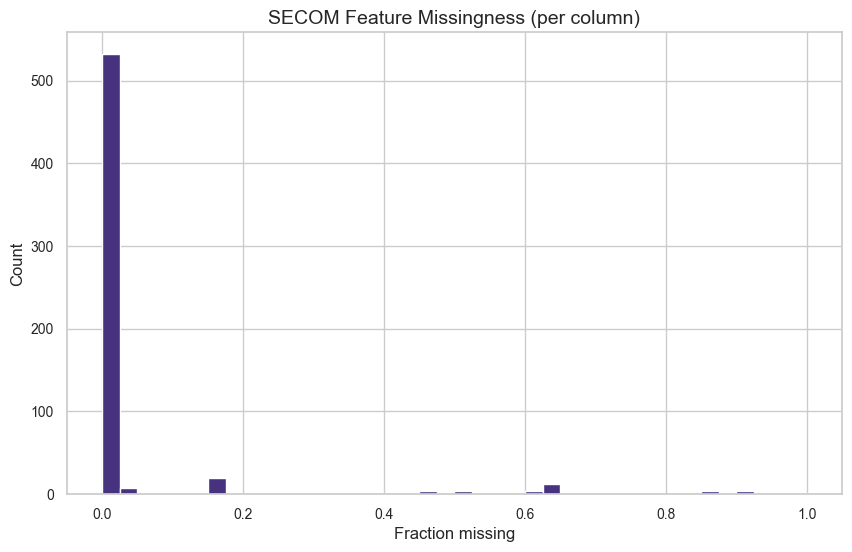

  → Saved to results/plot_cell_19.png


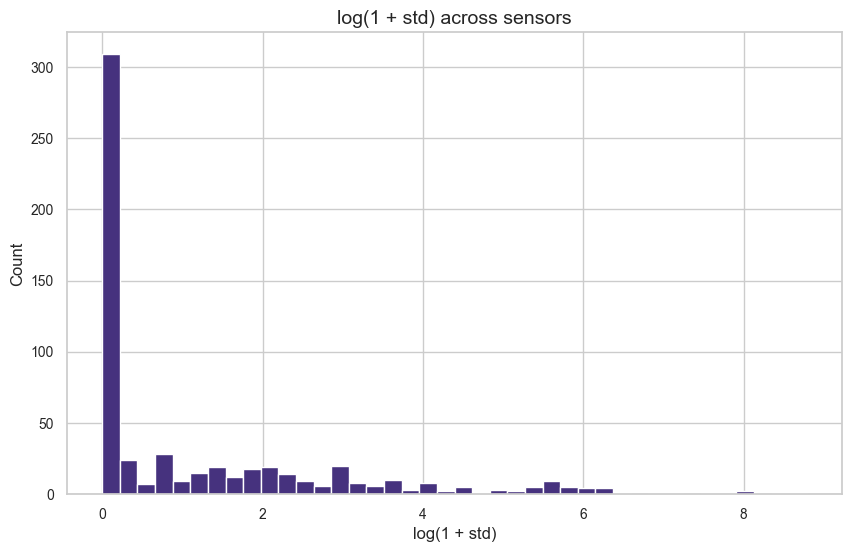

  → Saved to results/plot_cell_19.png


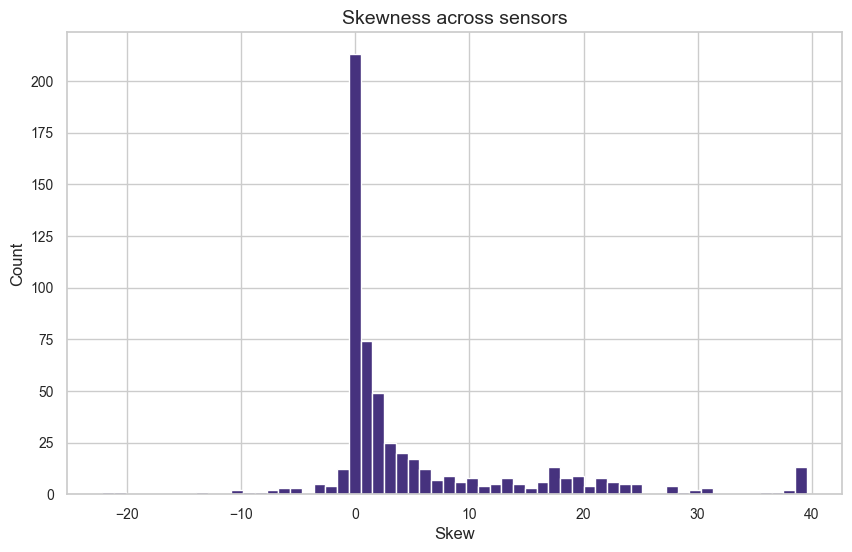

In [19]:
plt.figure()
plt.hist(missing_pct.values, bins=40)
plt.title("SECOM Feature Missingness (per column)")
plt.xlabel("Fraction missing")
plt.ylabel("Count")
plt.savefig('results/plot_cell_19.png', dpi=300, bbox_inches='tight')
print('  → Saved to results/plot_cell_19.png')
plt.show()

plt.figure()
plt.hist(np.log1p(stds.replace([np.inf, -np.inf], np.nan).dropna().values), bins=40)
plt.title("log(1 + std) across sensors")
plt.xlabel("log(1 + std)")
plt.ylabel("Count")
plt.savefig('results/plot_cell_19.png', dpi=300, bbox_inches='tight')
print('  → Saved to results/plot_cell_19.png')
plt.show()

plt.figure()
plt.hist(skew.replace([np.inf, -np.inf], np.nan).dropna().values, bins=60)
plt.title("Skewness across sensors")
plt.xlabel("Skew")
plt.ylabel("Count")
plt.savefig('results/plot_cell_19.png', dpi=300, bbox_inches='tight')
print('  → Saved to results/plot_cell_19.png')
plt.show()


103    0.172453
510    0.143783
59     0.125891
348    0.111400
129    0.107639
431    0.105535
64     0.103988
21     0.099321
125    0.094642
430    0.092835
434    0.092362
100    0.091893
dtype: float64

  → Saved to results/sensor_boxplots.png


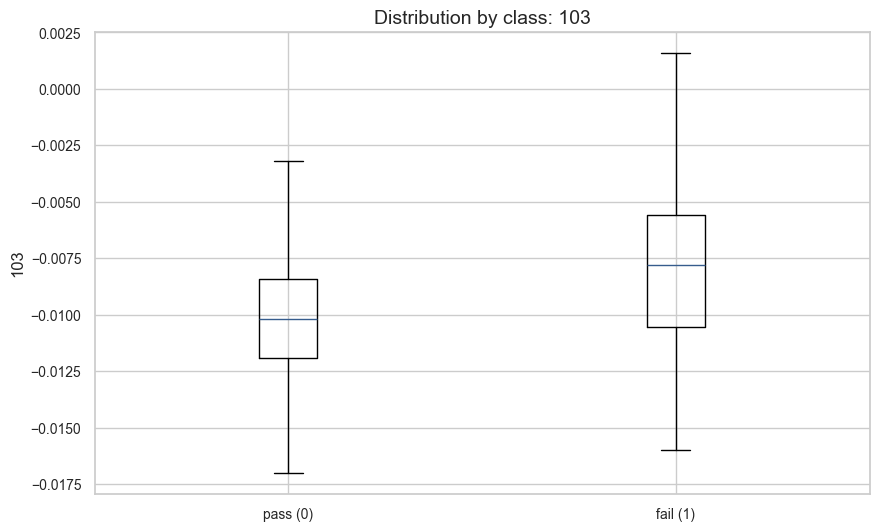

  → Saved to results/sensor_boxplots.png


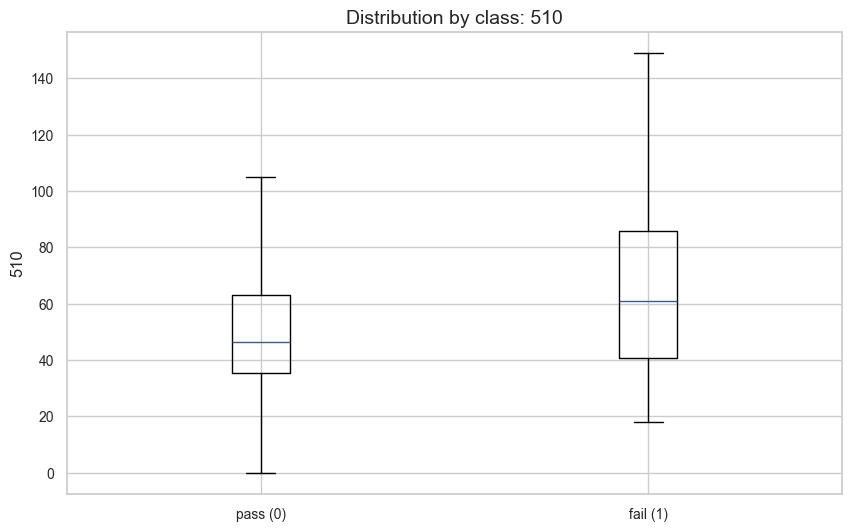

  → Saved to results/sensor_boxplots.png


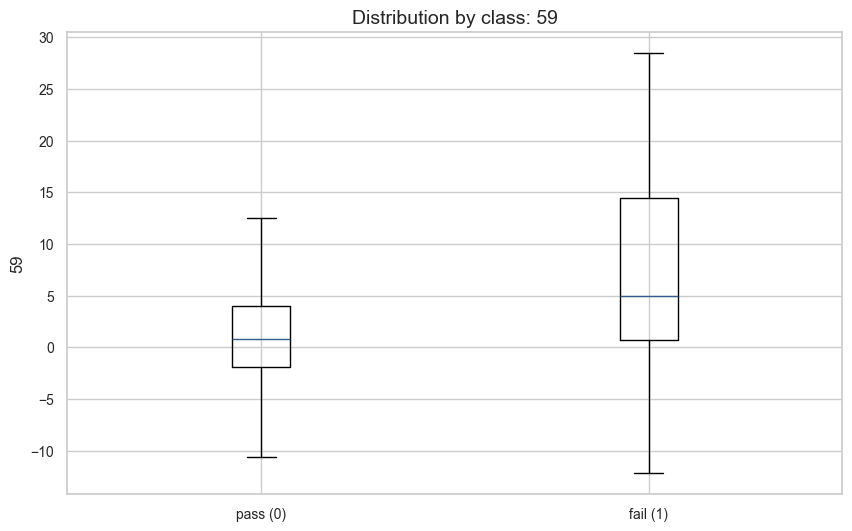

  → Saved to results/sensor_boxplots.png


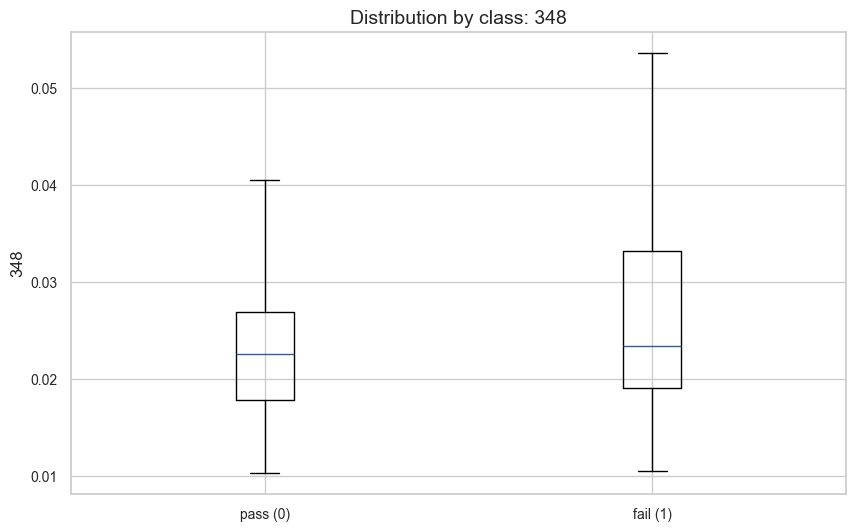

  → Saved to results/sensor_boxplots.png


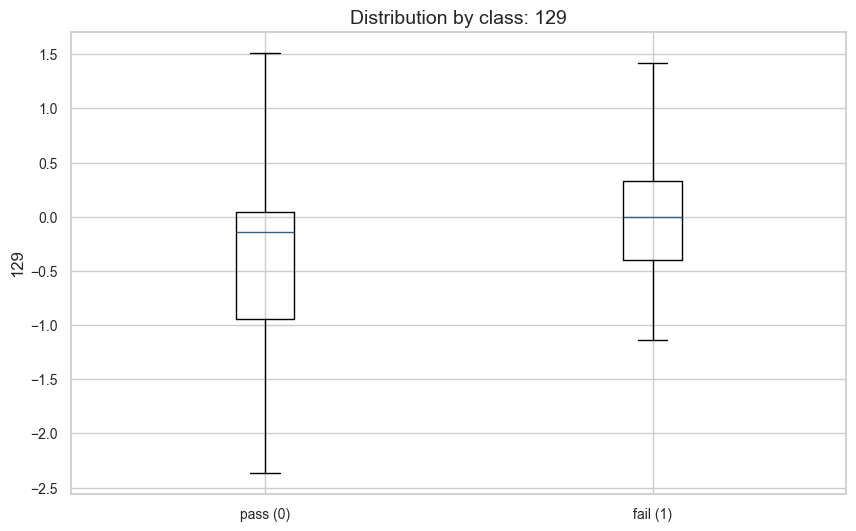

  → Saved to results/sensor_boxplots.png


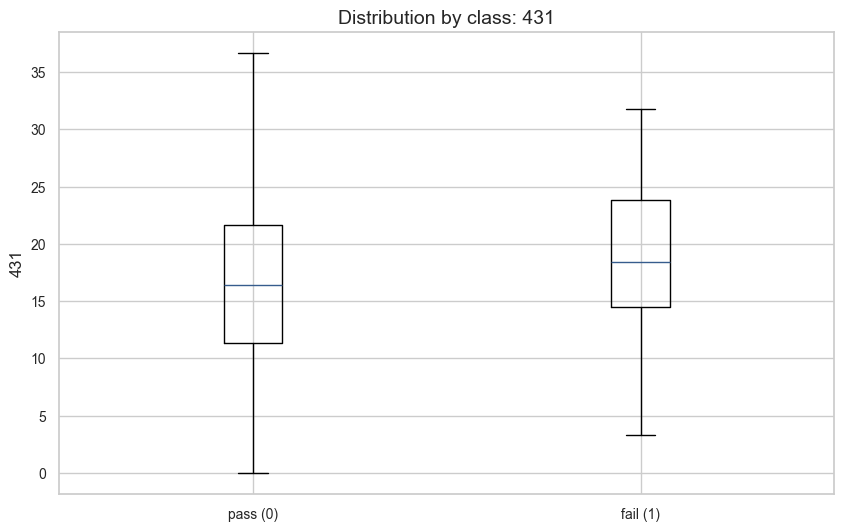

  → Saved to results/sensor_boxplots.png


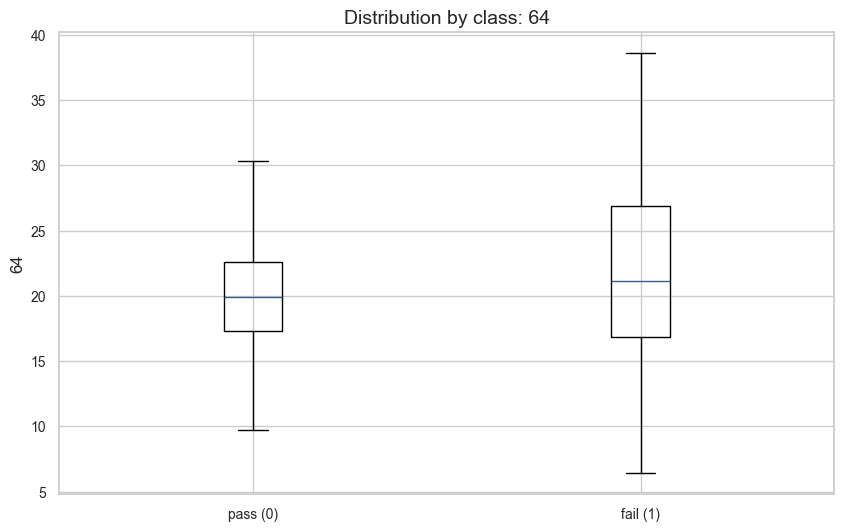

  → Saved to results/sensor_boxplots.png


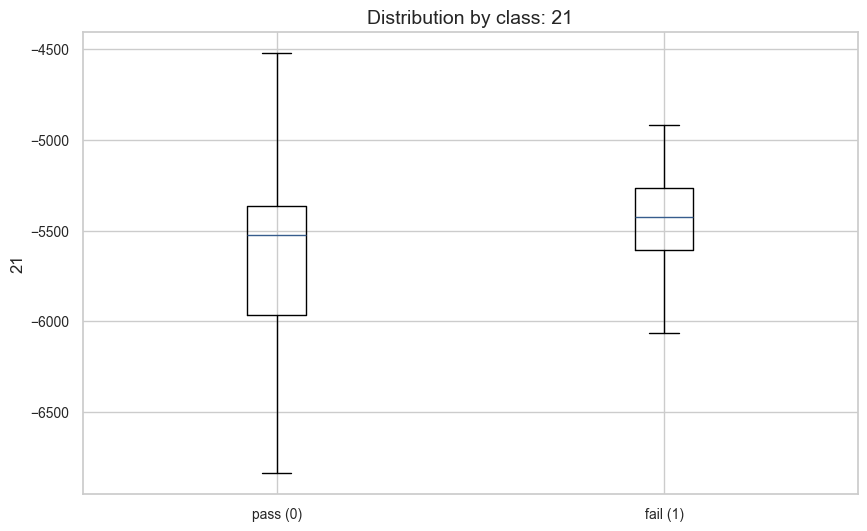

  → Saved to results/sensor_boxplots.png


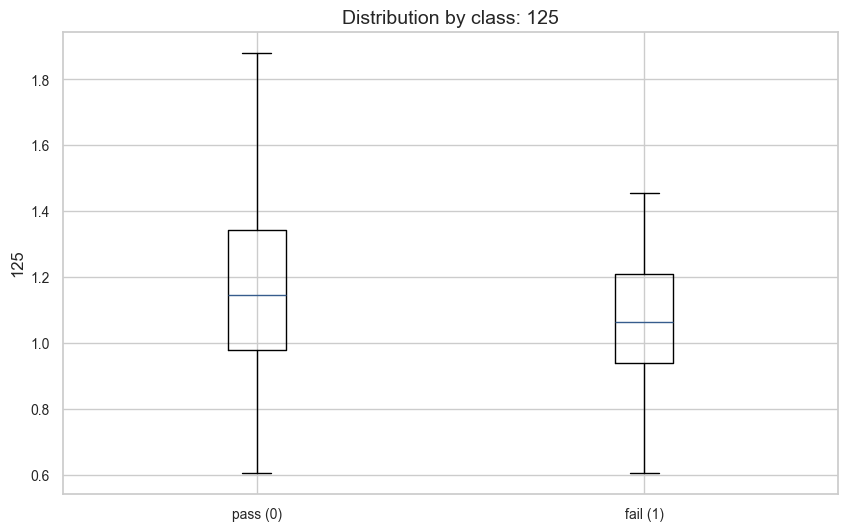

  → Saved to results/sensor_boxplots.png


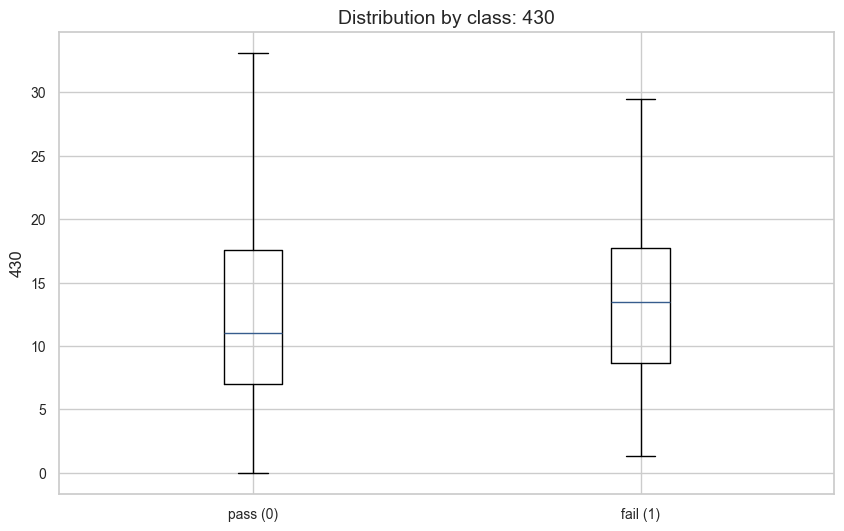

  → Saved to results/sensor_boxplots.png


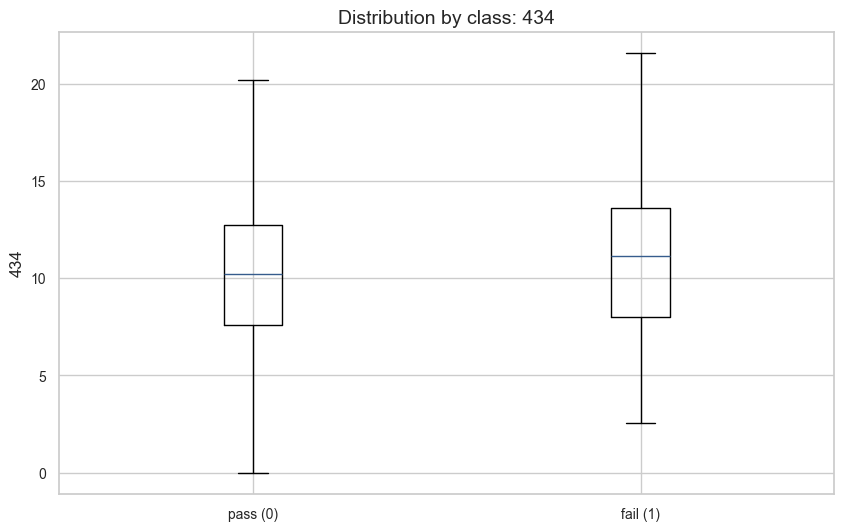

  → Saved to results/sensor_boxplots.png


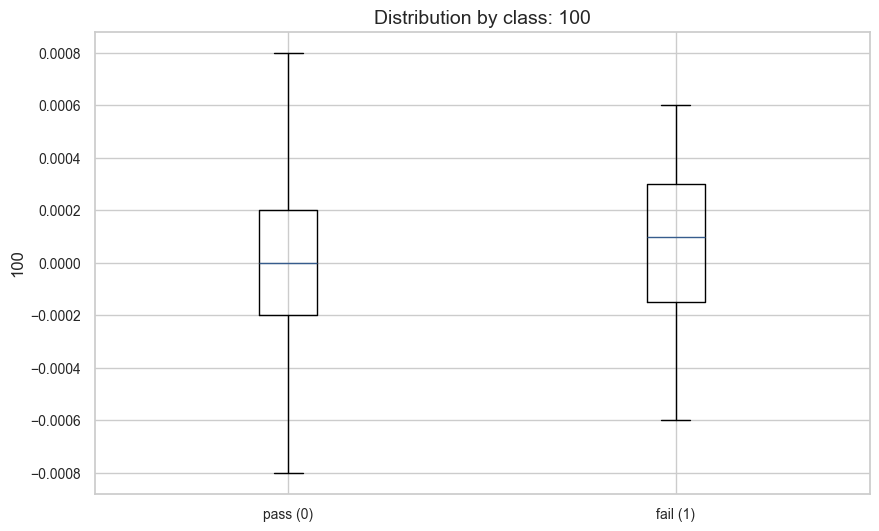

In [20]:
from scipy.stats import pointbiserialr

# Use your train split (X_train_raw, y_train) from earlier
Xtr = X_train_raw.copy()  # raw numeric sensors (pre-pruning is fine for EDA)
ytr = y_train.values

# Median-impute just for scoring plots (not your final modeling pipeline)
med = Xtr.median()
Xtr_imp = Xtr.fillna(med)

scores = {}
for c in Xtr_imp.columns:
    x = Xtr_imp[c].values
    if np.std(x) == 0:
        continue
    scores[c] = abs(pointbiserialr(x, ytr).correlation)

top_feats = pd.Series(scores).sort_values(ascending=False).head(12)
display(top_feats)

# Plot distributions for top features (boxplot by class)
for c in top_feats.index:
    x0 = Xtr_imp.loc[y_train == 0, c].values
    x1 = Xtr_imp.loc[y_train == 1, c].values

    plt.figure()
    plt.boxplot([x0, x1], labels=["pass (0)", "fail (1)"], showfliers=False)
    plt.title(f"Distribution by class: {c}")
    plt.ylabel(c)
    plt.savefig('results/sensor_boxplots.png', dpi=300, bbox_inches='tight')
    print('  → Saved to results/sensor_boxplots.png')
    plt.show()


  → Saved to results/plot_cell_21.png


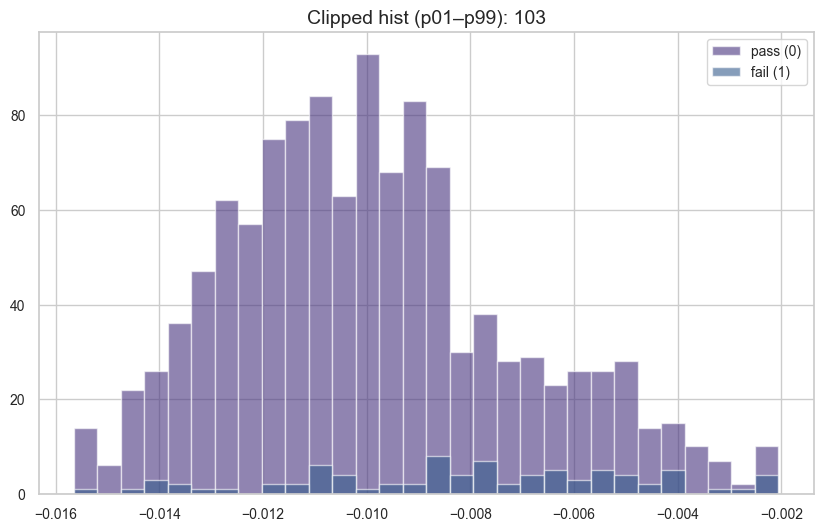

  → Saved to results/plot_cell_21.png


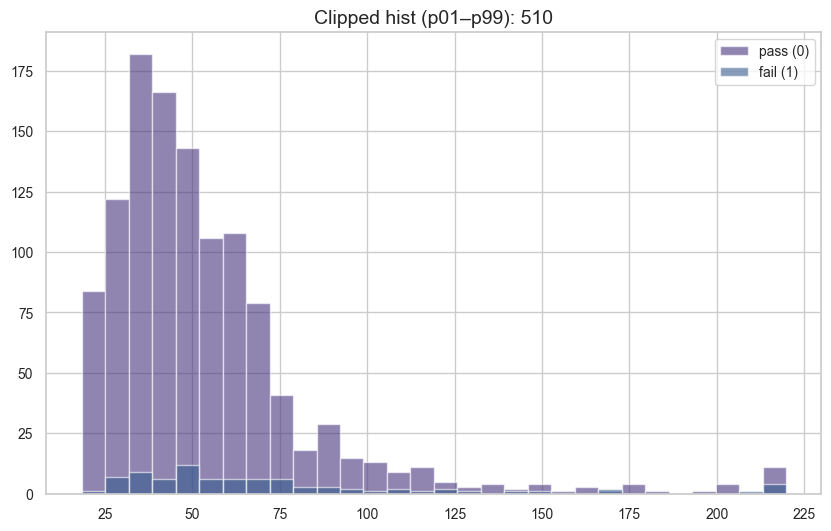

  → Saved to results/plot_cell_21.png


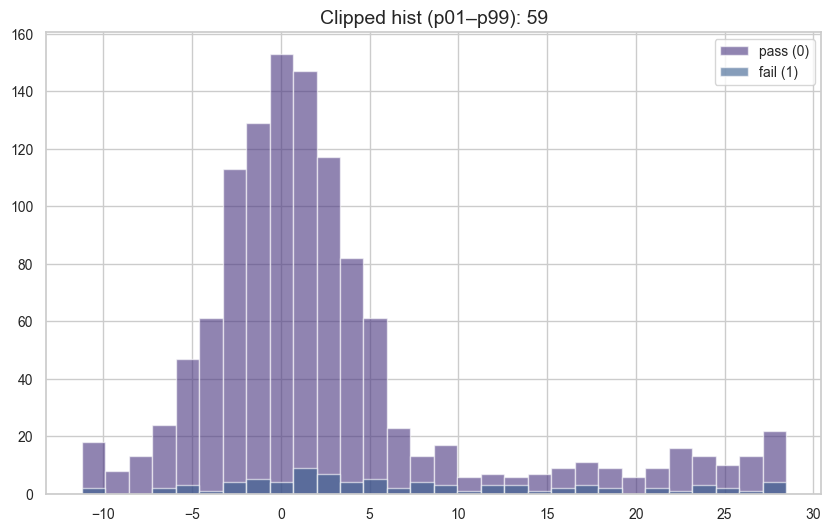

  → Saved to results/plot_cell_21.png


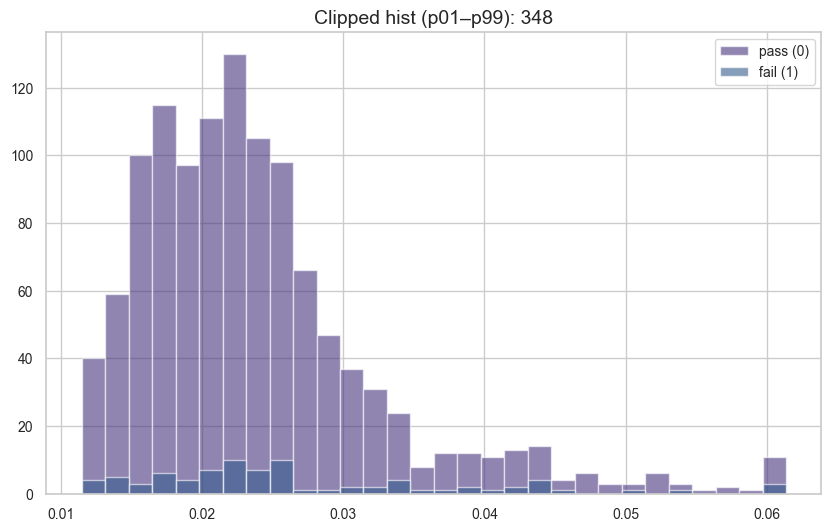

  → Saved to results/plot_cell_21.png


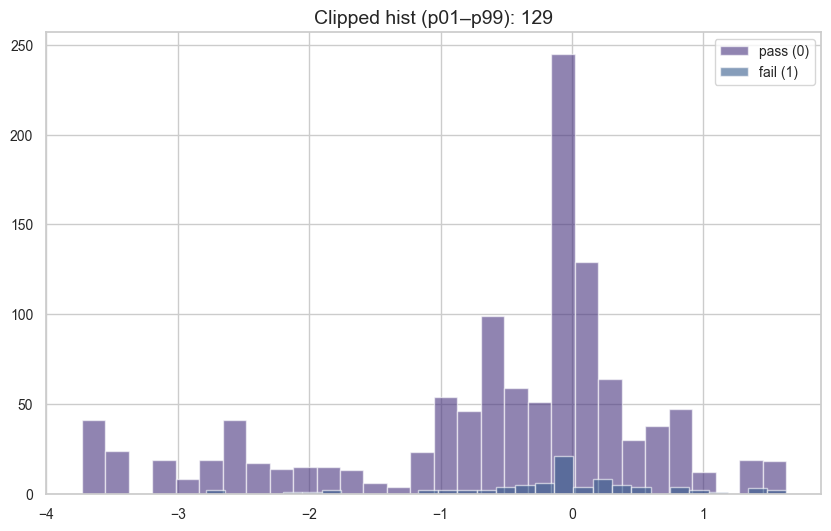

  → Saved to results/plot_cell_21.png


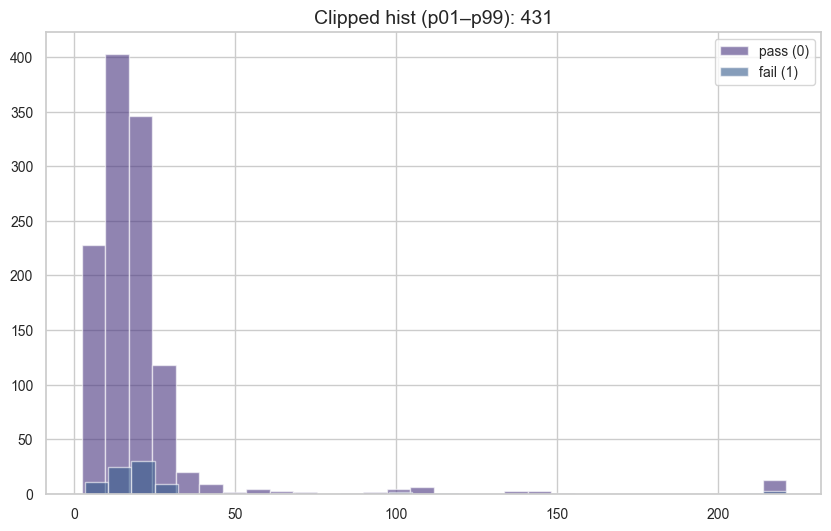

  → Saved to results/plot_cell_21.png


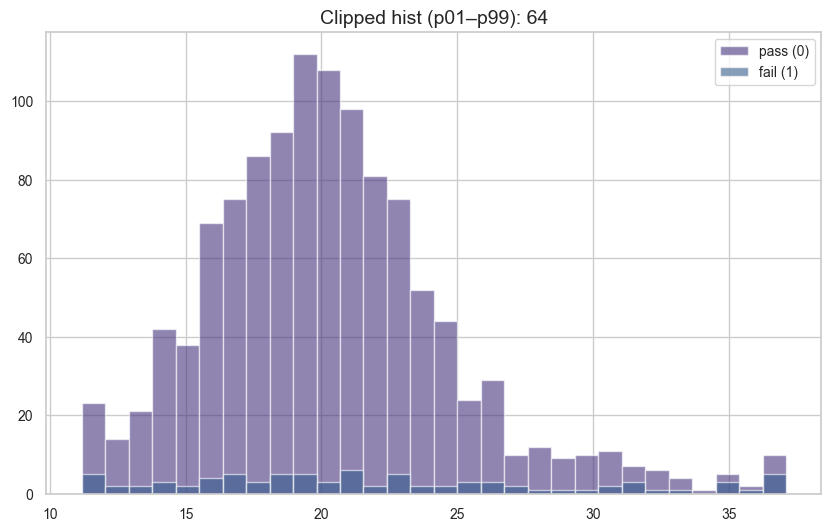

  → Saved to results/plot_cell_21.png


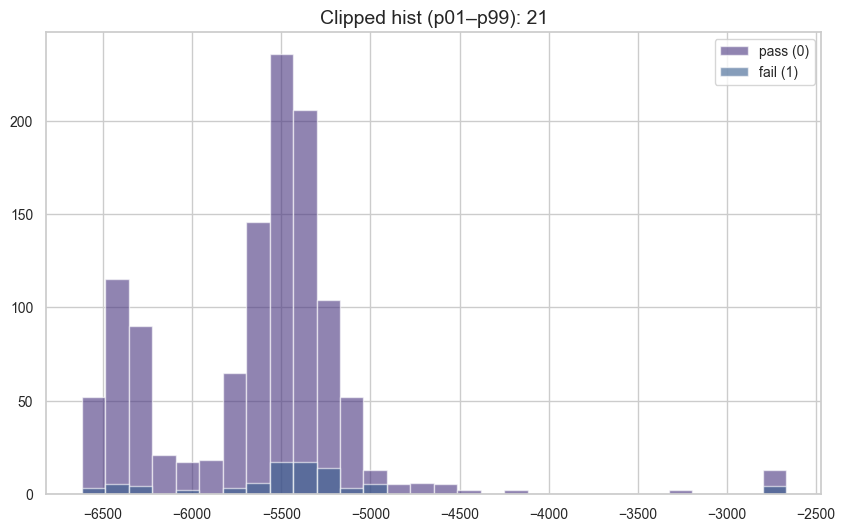

  → Saved to results/plot_cell_21.png


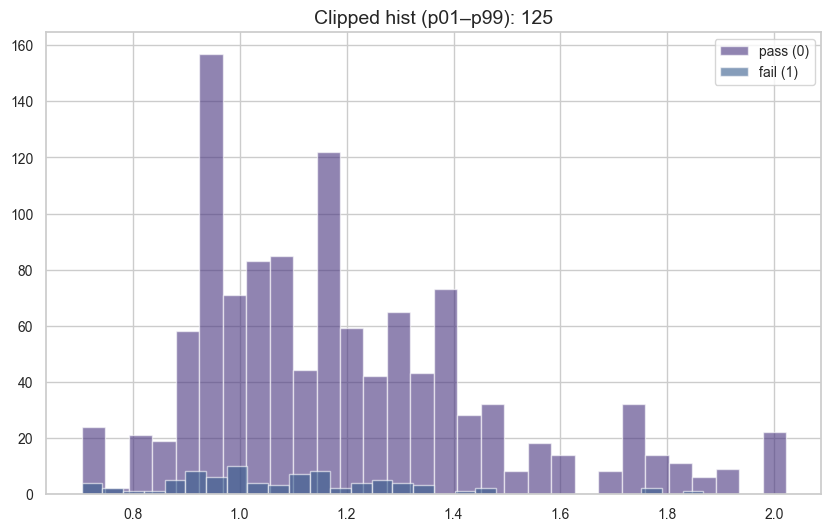

  → Saved to results/plot_cell_21.png


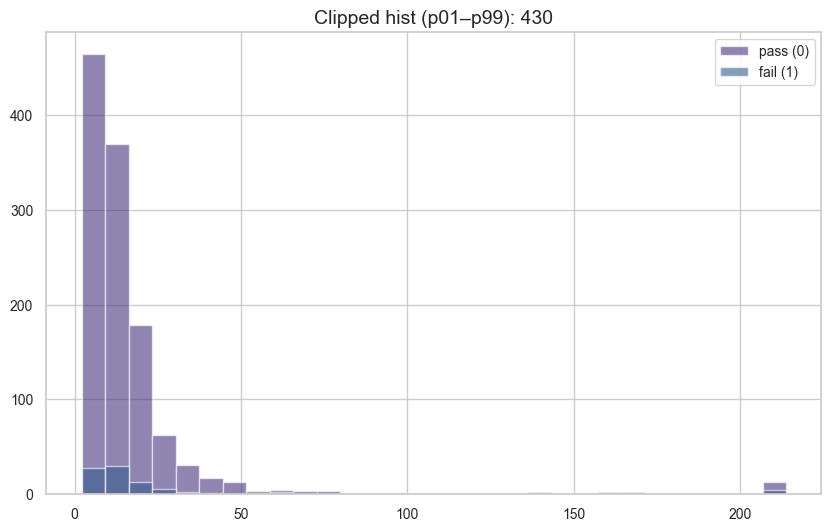

  → Saved to results/plot_cell_21.png


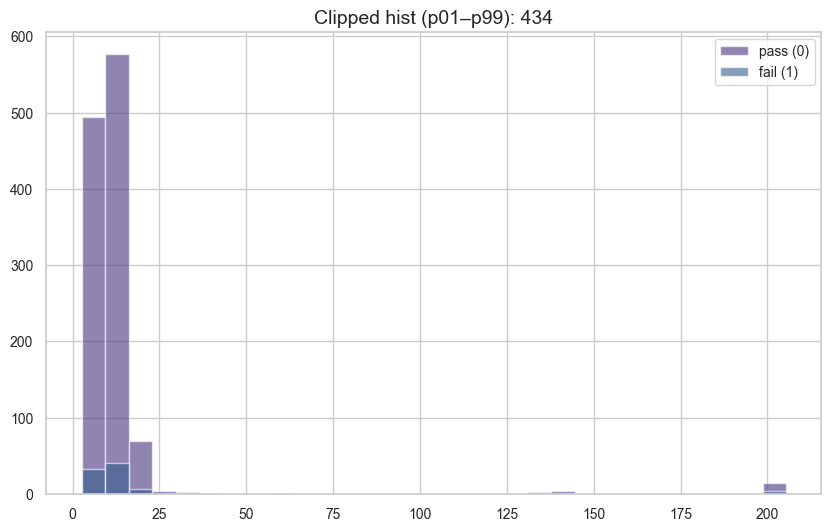

  → Saved to results/plot_cell_21.png


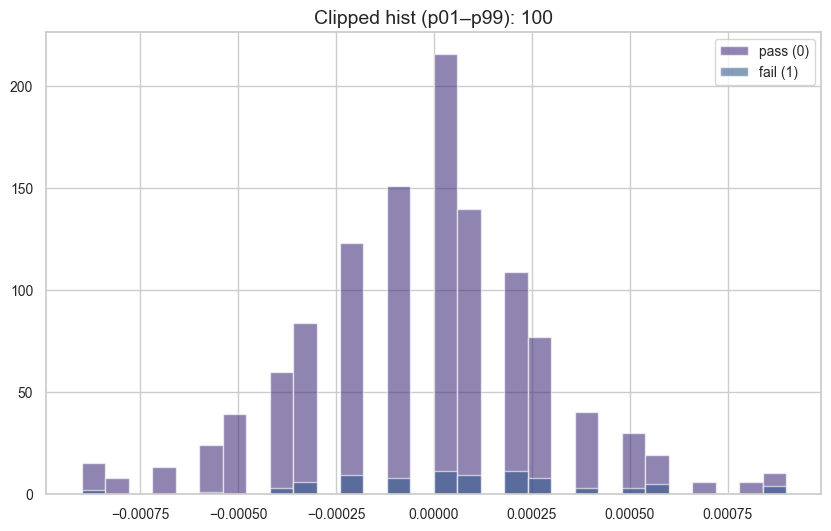

In [21]:
for c in top_feats.index:
    tmp = Xtr_imp[[c]].copy()
    lo, hi = tmp[c].quantile([0.01, 0.99])
    x_pass = tmp.loc[y_train == 0, c].clip(lo, hi).values
    x_fail = tmp.loc[y_train == 1, c].clip(lo, hi).values

    plt.figure()
    plt.hist(x_pass, bins=30, alpha=0.6, label="pass (0)")
    plt.hist(x_fail, bins=30, alpha=0.6, label="fail (1)")
    plt.title(f"Clipped hist (p01–p99): {c}")
    plt.legend()
    plt.savefig('results/plot_cell_21.png', dpi=300, bbox_inches='tight')
    print('  → Saved to results/plot_cell_21.png')
    plt.show()




## Final EDA Summary (SECOM)

This SECOM dataset has **1,567 rows** with **593 sensor features** (plus a Time column) and a highly **imbalanced target**: roughly **93.4% pass (0)** vs **6.6% fail (1)**. That imbalance means overall accuracy is not meaningful, and model selection/evaluation should be centered on **recall, PR-AUC, and alert-rate tradeoffs** (since the operational question is usually “how many wafers do we flag to catch most failures?”).

From a data-quality standpoint, the sensors are heterogeneous. You observed **117 constant (std = 0) features**, which are non-informative and should be removed early. Missingness is also uneven: **most sensors have near-zero missingness**, but there is a clear long tail of sensors with **very high missing rates** (some around **65%–90%** missing). That pattern is consistent with “sensors down / not collected for certain runs / configuration changes,” and it’s important because missingness can be both (a) an engineering issue to address for stable deployment and (b) a **predictive signal**.

When you grouped outcomes by row-level missingness, the **fail rate varied across missingness bins** (not monotonic, but meaningfully different in places), and your quick coefficient ranking suggested **row_missing_pct** and a handful of **missing flags** are among the more influential indicators. That supports a pragmatic approach: **drop the worst-offending high-missing sensors**, do **train-only median imputation** for the rest, and **keep a limited set of missingness indicators** (row_missing_pct + a small number of top missing flags), instead of keeping hundreds of missing flags that can add noise and inflate dimensionality.

Finally, the per-feature distribution plots show many sensors are **skewed/heavy-tailed** with outliers and scale differences. That favors robust preprocessing and models that tolerate non-normality (tree ensembles or linear models with robust scaling), and it also justifies your clipping (p01–p99) for visualization and the later steps of **variance filtering + correlation pruning** to reduce redundancy.

**Bottom line:** your approach is correct, and this EDA supports your pipeline decisions: (1) handle class imbalance explicitly, (2) prune constant/high-missing/redundant sensors, (3) impute using train-only statistics, (4) treat missingness as a controlled feature (not an uncontrolled explosion), and (5) validate model stability via **recall-per-fold** and **subgroup recall** (high/low missingness, time bins, sensor quantile bins) so “good recall” is not just a fragile artifact of one split.


Top-12 by |Cohen's d|:


feature   cohen_d  abs_cohen_d
0      103  0.702735     0.702735
1       85 -0.587526     0.587526
2      510  0.582945     0.582945
3       59  0.508066     0.508066
4      158  0.500702     0.500702
5      293  0.495421     0.495421
6      111 -0.445679     0.445679
7      348  0.444471     0.444471
8      129  0.436446     0.436446
9      431  0.426101     0.426101
10      64  0.418892     0.418892
11     220 -0.412918     0.412918

  → Saved to results/sensor_boxplots.png


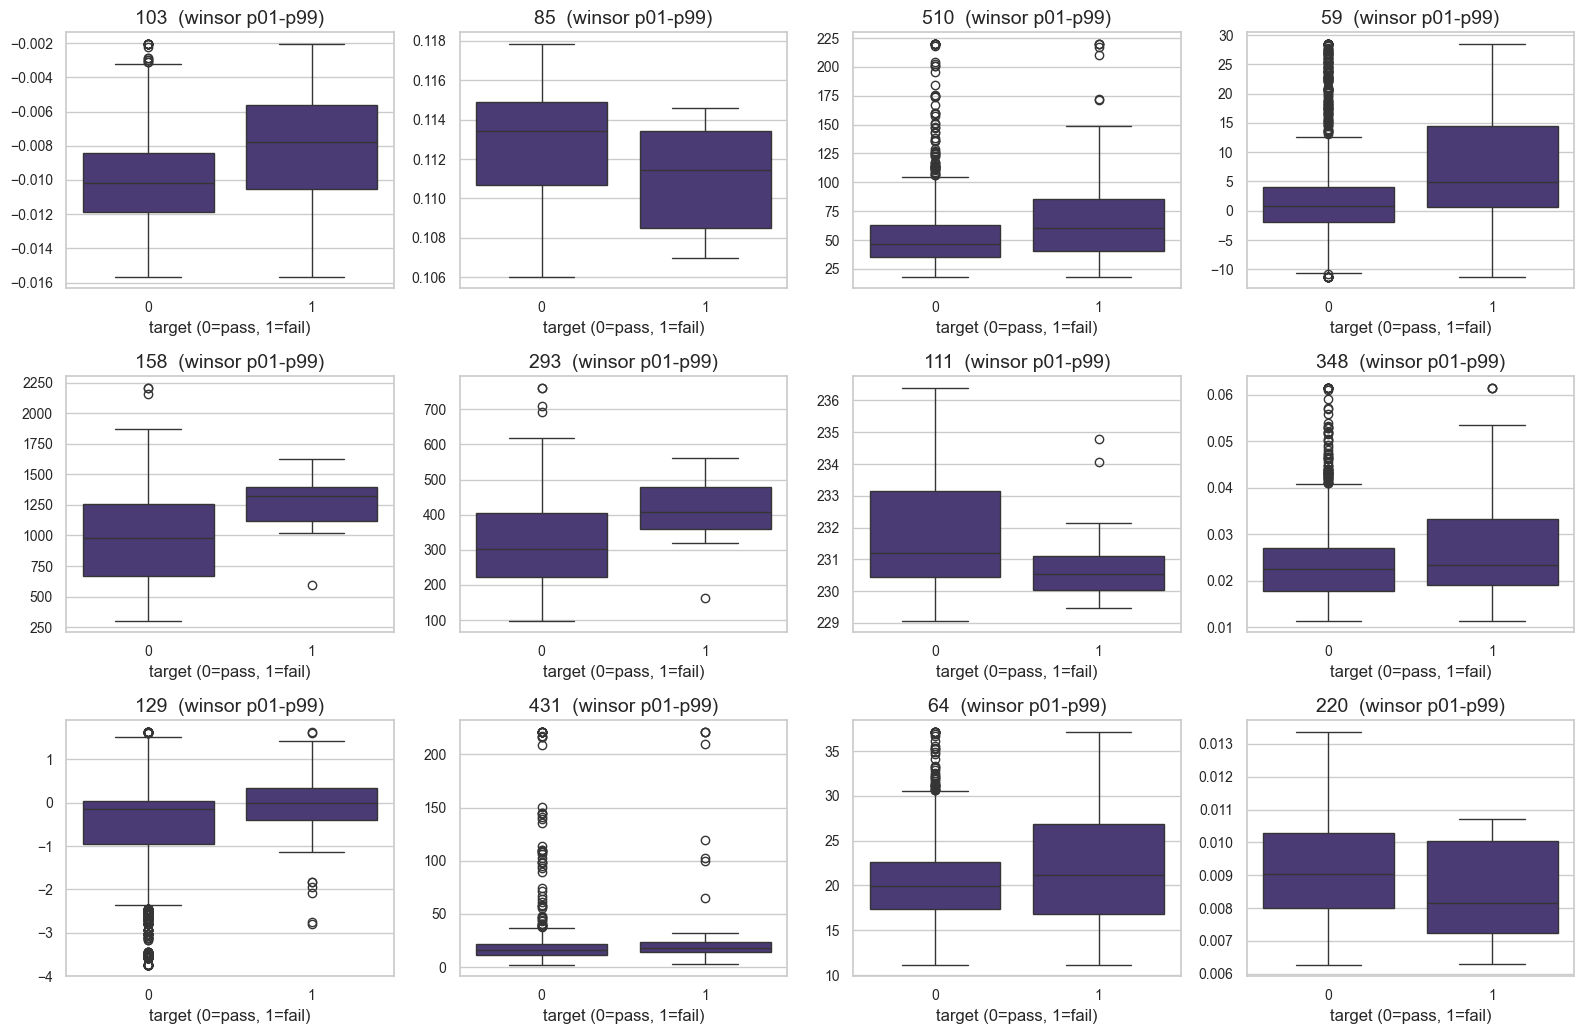

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# =========================
# 0) Setup: target + time
# =========================
TARGET_RAW = "Pass/Fail"   # raw label column (likely -1 pass, 1 fail)
TIME_COL   = "Time"

df_work = df.copy()

# Create y if missing: pass=-1 -> 0, fail=1 -> 1
if "y" not in df_work.columns:
    df_work["y"] = (df_work[TARGET_RAW] == 1).astype(int)

# -------------------------
# 1) Parse Time + time feats
# -------------------------
if TIME_COL in df_work.columns:
    df_work[TIME_COL] = pd.to_datetime(df_work[TIME_COL], errors="coerce")

    # Basic time-derived features
    df_work["time_year"]      = df_work[TIME_COL].dt.year
    df_work["time_month"]     = df_work[TIME_COL].dt.month
    df_work["time_dayofweek"] = df_work[TIME_COL].dt.dayofweek
    df_work["time_hour"]      = df_work[TIME_COL].dt.hour
    df_work["time_dayofyear"] = df_work[TIME_COL].dt.dayofyear

    # Optional: numeric time since start (minutes)
    t0 = df_work[TIME_COL].min()
    df_work["time_minutes_since_start"] = (df_work[TIME_COL] - t0).dt.total_seconds() / 60.0

# -------------------------
# 2) Build X (numeric features for ranking)
#    (exclude raw label + raw Time)
# -------------------------
drop_cols = [TARGET_RAW, "y"]
if TIME_COL in df_work.columns:
    drop_cols.append(TIME_COL)

X_all = df_work.drop(columns=drop_cols, errors="ignore").apply(pd.to_numeric, errors="coerce")
y_all = df_work["y"].astype(int)

# Stratified split (TRAIN ONLY will be used for ranking/EDA)
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X_all, y_all, test_size=0.20, random_state=42, stratify=y_all
)

# Defensive alignment checks (prevents your mismatch error)
assert X_train.shape[0] == y_train.shape[0], "X_train and y_train row counts differ"
assert X_train.index.equals(y_train.index), "X_train and y_train indices are not aligned"

# =========================
# 3) Effect size: Cohen's d
# =========================
def cohen_d(x0, x1):
    """Cohen's d for two groups; returns signed effect size (fail - pass)."""
    x0 = x0.dropna()
    x1 = x1.dropna()
    if len(x0) < 5 or len(x1) < 5:
        return np.nan
    s0 = x0.std(ddof=1)
    s1 = x1.std(ddof=1)
    sp = np.sqrt(((len(x0) - 1) * s0 * s0 + (len(x1) - 1) * s1 * s1) / (len(x0) + len(x1) - 2))
    if sp == 0 or np.isnan(sp):
        return 0.0
    return (x1.mean() - x0.mean()) / sp

effects = []
for col in X_train.columns:
    d = cohen_d(X_train.loc[y_train == 0, col], X_train.loc[y_train == 1, col])
    effects.append((col, d, np.abs(d)))

rank_df = (
    pd.DataFrame(effects, columns=["feature", "cohen_d", "abs_cohen_d"])
      .dropna()
      .sort_values("abs_cohen_d", ascending=False)
      .reset_index(drop=True)
)

top_feats = rank_df.head(12)["feature"].tolist()
print("Top-12 by |Cohen's d|:")
display(rank_df.head(12))

# =========================
# 4) Boxplots for top-12 (winsorized p01–p99)
#    FIX: align by index, do NOT reset only y
# =========================
def winsorize_series(s, p_low=0.01, p_high=0.99):
    lo = s.quantile(p_low)
    hi = s.quantile(p_high)
    return s.clip(lo, hi)

Xtr_plot = X_train[top_feats].copy()
ytr_plot = y_train.copy()

# Explicit alignment (robust even if you later reset indices elsewhere)
Xtr_plot = Xtr_plot.loc[ytr_plot.index]

long_df_parts = []
for f in top_feats:
    long_df_parts.append(pd.DataFrame({
        "feature": f,
        "value": winsorize_series(Xtr_plot[f]),
        "target": ytr_plot.values
    }))

long_df = pd.concat(long_df_parts, ignore_index=True)

# Plot: 12 panels
n = len(top_feats)
ncols = 4
nrows = int(np.ceil(n / ncols))

plt.figure(figsize=(16, 3.5 * nrows))
for i, f in enumerate(top_feats, 1):
    ax = plt.subplot(nrows, ncols, i)
    sub = long_df[long_df["feature"] == f]
    sns.boxplot(data=sub, x="target", y="value", ax=ax)
    ax.set_title(f"{f}  (winsor p01-p99)")
    ax.set_xlabel("target (0=pass, 1=fail)")
    ax.set_ylabel("")
plt.tight_layout()
plt.savefig('results/sensor_boxplots.png', dpi=300, bbox_inches='tight')
print('  → Saved to results/sensor_boxplots.png')
plt.show()


In [23]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# ----------------------------
# Helpers
# ----------------------------
def best_f1_threshold(y_true, p):
    """Pick threshold that maximizes F1 on given probabilities."""
    prec, rec, thr = precision_recall_curve(y_true, p)
    # precision_recall_curve returns thresholds of length n-1
    f1 = (2 * prec * rec) / (prec + rec + 1e-12)
    best_idx = np.nanargmax(f1)
    if best_idx == len(thr):  # edge case
        return 0.5
    return float(thr[best_idx])

def eval_at_threshold(y_true, p, thr):
    yhat = (p >= thr).astype(int)
    return {
        "precision": precision_score(y_true, yhat, zero_division=0),
        "recall": recall_score(y_true, yhat, zero_division=0),
        "f1": f1_score(y_true, yhat, zero_division=0),
        "pr_auc": average_precision_score(y_true, p),
        "roc_auc": roc_auc_score(y_true, p),
    }

def cross_val_oof_probs(model, X, y, n_splits=5, random_state=42):
    """Out-of-fold probabilities for class 1."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    p_oof = np.zeros(len(y), dtype=float)

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        model.fit(X_tr, y_tr)
        p_oof[va_idx] = model.predict_proba(X_va)[:, 1]

    return p_oof

# ----------------------------
# 1) Create a "no missing flags" version
#    (keep row_missing_pct if you want)
# ----------------------------
missing_flag_cols = [c for c in X_train_final.columns if str(c).endswith("_missing")]
base_cols = [c for c in X_train_final.columns if c not in missing_flag_cols]

# Option A: keep row_missing_pct (recommended)
# Option B: drop row_missing_pct too (for a stricter comparison)
X_train_base = X_train_final[base_cols].copy()

# ----------------------------
# 2) Define a simple baseline model
#    Logistic is good for this specific diagnostic.
#    (trees can hide missingness effects differently)
# ----------------------------
logit = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        max_iter=4000,
        class_weight="balanced",  # important due to 6.6% positive class
        n_jobs=None
    ))
])

# ----------------------------
# 3) Missingness predictive check:
#    Compare OOF performance:
#      - with missing flags
#      - without missing flags
# ----------------------------
y_train_s = y_train.reset_index(drop=True)
X_train_final_s = X_train_final.reset_index(drop=True)
X_train_base_s  = X_train_base.reset_index(drop=True)

p_oof_with = cross_val_oof_probs(logit, X_train_final_s, y_train_s, n_splits=5)
p_oof_base = cross_val_oof_probs(logit, X_train_base_s,  y_train_s, n_splits=5)

thr_with = best_f1_threshold(y_train_s, p_oof_with)
thr_base = best_f1_threshold(y_train_s, p_oof_base)

print("OOF metrics (WITH missing flags):", eval_at_threshold(y_train_s, p_oof_with, thr_with), "thr=", round(thr_with, 3))
print("OOF metrics (NO missing flags):  ", eval_at_threshold(y_train_s, p_oof_base, thr_base), "thr=", round(thr_base, 3))

# Interpretation:
# - If recall/PR-AUC barely moves, you can drop most missing flags.
# - If recall meaningfully improves, keep row_missing_pct + top N missing flags.
# ----------------------------

# ----------------------------
# 4) Recall per fold (at a consistent threshold)
#    Use OOF threshold, then report per-fold recall at that threshold.
# ----------------------------
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_rows = []

# pick one model variant to audit:
X_use = X_train_final_s
thr = thr_with

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_use, y_train_s), 1):
    X_tr, X_va = X_use.iloc[tr_idx], X_use.iloc[va_idx]
    y_tr, y_va = y_train_s.iloc[tr_idx], y_train_s.iloc[va_idx]

    logit.fit(X_tr, y_tr)
    p_va = logit.predict_proba(X_va)[:, 1]
    m = eval_at_threshold(y_va, p_va, thr)
    m["fold"] = fold
    m["n_val"] = len(va_idx)
    m["fail_rate_val"] = float(y_va.mean())
    fold_rows.append(m)

fold_df = pd.DataFrame(fold_rows).sort_values("fold")
display(fold_df)

# ----------------------------
# 5) Subgroup recall (detect fragile recall)
#    - High vs low row_missing_pct
#    - Time bins if time_minutes_since_start exists in X_train_final
#    - Sensor quantile bins for a top sensor (example: "103")
# ----------------------------
# Use OOF probabilities (so subgroup eval is not inflated)
p_oof = p_oof_with
y_true = y_train_s
yhat = (p_oof >= thr_with).astype(int)

audit = X_train_final_s.copy()
audit["y"] = y_true.values
audit["p"] = p_oof
audit["yhat"] = yhat

def subgroup_recall(df, mask, label):
    sub = df.loc[mask]
    if sub["y"].sum() == 0:
        return {"group": label, "n": len(sub), "fails": 0, "recall": np.nan}
    rec = recall_score(sub["y"], sub["yhat"], zero_division=0)
    return {"group": label, "n": len(sub), "fails": int(sub["y"].sum()), "recall": float(rec)}

rows = []

# (a) row_missing_pct high vs low
if "row_missing_pct" in audit.columns:
    q = audit["row_missing_pct"].quantile(0.75)
    rows.append(subgroup_recall(audit, audit["row_missing_pct"] >= q, "row_missing_pct: top 25%"))
    rows.append(subgroup_recall(audit, audit["row_missing_pct"] <  q, "row_missing_pct: bottom 75%"))

# (b) time bins
if "time_minutes_since_start" in audit.columns:
    med = audit["time_minutes_since_start"].median()
    rows.append(subgroup_recall(audit, audit["time_minutes_since_start"] <= med, "time: early half"))
    rows.append(subgroup_recall(audit, audit["time_minutes_since_start"] >  med, "time: late half"))

# (c) top sensor quantile bins (replace "103" with any sensor column you want)
SENSOR_COL = "103"
if SENSOR_COL in audit.columns:
    q_hi = audit[SENSOR_COL].quantile(0.75)
    q_lo = audit[SENSOR_COL].quantile(0.25)
    rows.append(subgroup_recall(audit, audit[SENSOR_COL] >= q_hi, f"{SENSOR_COL}: top 25%"))
    rows.append(subgroup_recall(audit, audit[SENSOR_COL] <= q_lo, f"{SENSOR_COL}: bottom 25%"))

subgroup_df = pd.DataFrame(rows)
display(subgroup_df)


OOF metrics (WITH missing flags): {'precision': 0.12411347517730496, 'recall': 0.42168674698795183, 'f1': 0.1917808219178082, 'pr_auc': 0.12031659320421659, 'roc_auc': 0.6179075275460818} thr= 0.059
OOF metrics (NO missing flags):   {'precision': 0.16666666666666666, 'recall': 0.2289156626506024, 'f1': 0.19289340101522842, 'pr_auc': 0.11870071029374638, 'roc_auc': 0.6059005251776336} thr= 0.842


precision    recall        f1    pr_auc   roc_auc  fold  n_val  \
0   0.061224  0.176471  0.090909  0.092980  0.546757     1    251   
1   0.156250  0.588235  0.246914  0.220911  0.695827     2    251   
2   0.132075  0.411765  0.200000  0.140666  0.644042     3    251   
3   0.105263  0.375000  0.164384  0.074051  0.514957     4    250   
4   0.152542  0.562500  0.240000  0.244748  0.677885     5    250   

   fail_rate_val  
0       0.067729  
1       0.067729  
2       0.067729  
3       0.064000  
4       0.064000

group    n  fails    recall
0     row_missing_pct: top 25%  377     17  0.235294
1  row_missing_pct: bottom 75%  876     66  0.469697
2                 103: top 25%  320     45  0.511111
3              103: bottom 25%  322      9  0.444444

In [24]:
pos = int(y_train.sum())
neg = int((1 - y_train).sum())
print("Train pos (fail=1):", pos, "neg (pass=0):", neg, "ratio neg/pos:", neg/pos)


Train pos (fail=1): 83 neg (pass=0): 1170 ratio neg/pos: 14.096385542168674


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, average_precision_score

logit = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear"))
])

logit.fit(X_train_final, y_train)
p_hold = logit.predict_proba(X_hold_final)[:, 1]

prec, rec, thr = precision_recall_curve(y_holdout, p_hold)
f1 = (2*prec*rec)/(prec+rec+1e-12)
best_i = int(f1.argmax())
best_thr = 0.5 if len(thr)==0 else float(thr[min(best_i, len(thr)-1)])

yhat = (p_hold >= best_thr).astype(int)

print("Holdout PR-AUC:", average_precision_score(y_holdout, p_hold))
print("Best threshold:", best_thr)
print("Precision:", precision_score(y_holdout, yhat, zero_division=0))
print("Recall   :", recall_score(y_holdout, yhat, zero_division=0))
print("F1       :", f1_score(y_holdout, yhat, zero_division=0))


Holdout PR-AUC: 0.1329926394160364
Best threshold: 0.9535631013743018
Precision: 0.21052631578947367
Recall   : 0.19047619047619047
F1       : 0.2


Rows: 1567
Fail rate: 0.0664
y
pass(0)    1463
fail(1)     104
Name: count, dtype: int64

Sensor cols: 596

Top 15 missingness columns:


missing_bin    1.000000
293            0.911934
157            0.911934
158            0.911934
292            0.911934
220            0.855775
85             0.855775
492            0.855775
358            0.855775
517            0.649649
518            0.649649
111            0.649649
516            0.649649
383            0.649649
384            0.649649
dtype: float64


Row missingness summary:


count    1567.000000
mean        0.046597
std         0.022446
min         0.008389
25%         0.035235
50%         0.041946
75%         0.055369
90%         0.068792
95%         0.082215
max         0.256711
dtype: float64

  → Saved to results/sensor_boxplots.png


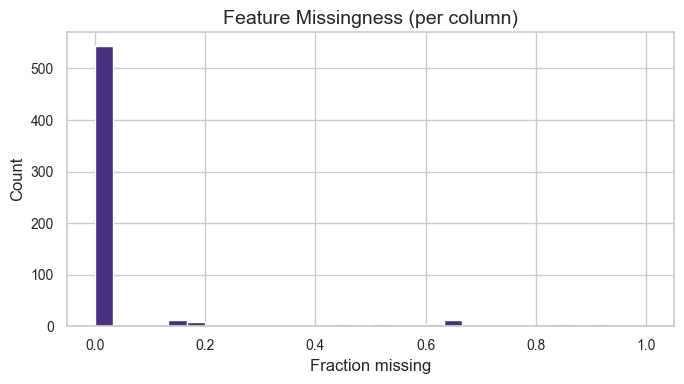

  → Saved to results/sensor_boxplots.png


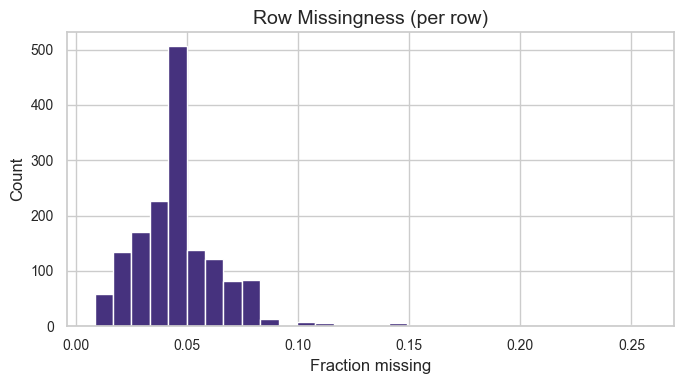


Fail rate by row-missingness quintile:


count  fail_rate  fail_rate_pct
missing_bin                                       
(0.00739, 0.0285]    362   0.052486           5.25
(0.0285, 0.0419]     465   0.096774           9.68
(0.0419, 0.0487]     267   0.063670           6.37
(0.0487, 0.0621]     258   0.034884           3.49
(0.0621, 0.257]      215   0.065116           6.51


Constant features (std=0): 116

Lowest non-zero std features:


95     0.000104
94     0.000174
101    0.000221
544    0.000296
278    0.000340
100    0.000356
358    0.000395
377    0.000467
357    0.000501
376    0.000534
dtype: float64


Top-12 by |Cohen's d| (train-only):


feature   cohen_d  abs_cohen_d
103     103  0.702735     0.702735
85       85 -0.587526     0.587526
510     510  0.582945     0.582945
59       59  0.508066     0.508066
158     158  0.500702     0.500702
293     293  0.495421     0.495421
111     111 -0.445679     0.445679
348     348  0.444471     0.444471
129     129  0.436446     0.436446
431     431  0.426101     0.426101
64       64  0.418892     0.418892
220     220 -0.412918     0.412918

  → Saved to results/sensor_boxplots.png


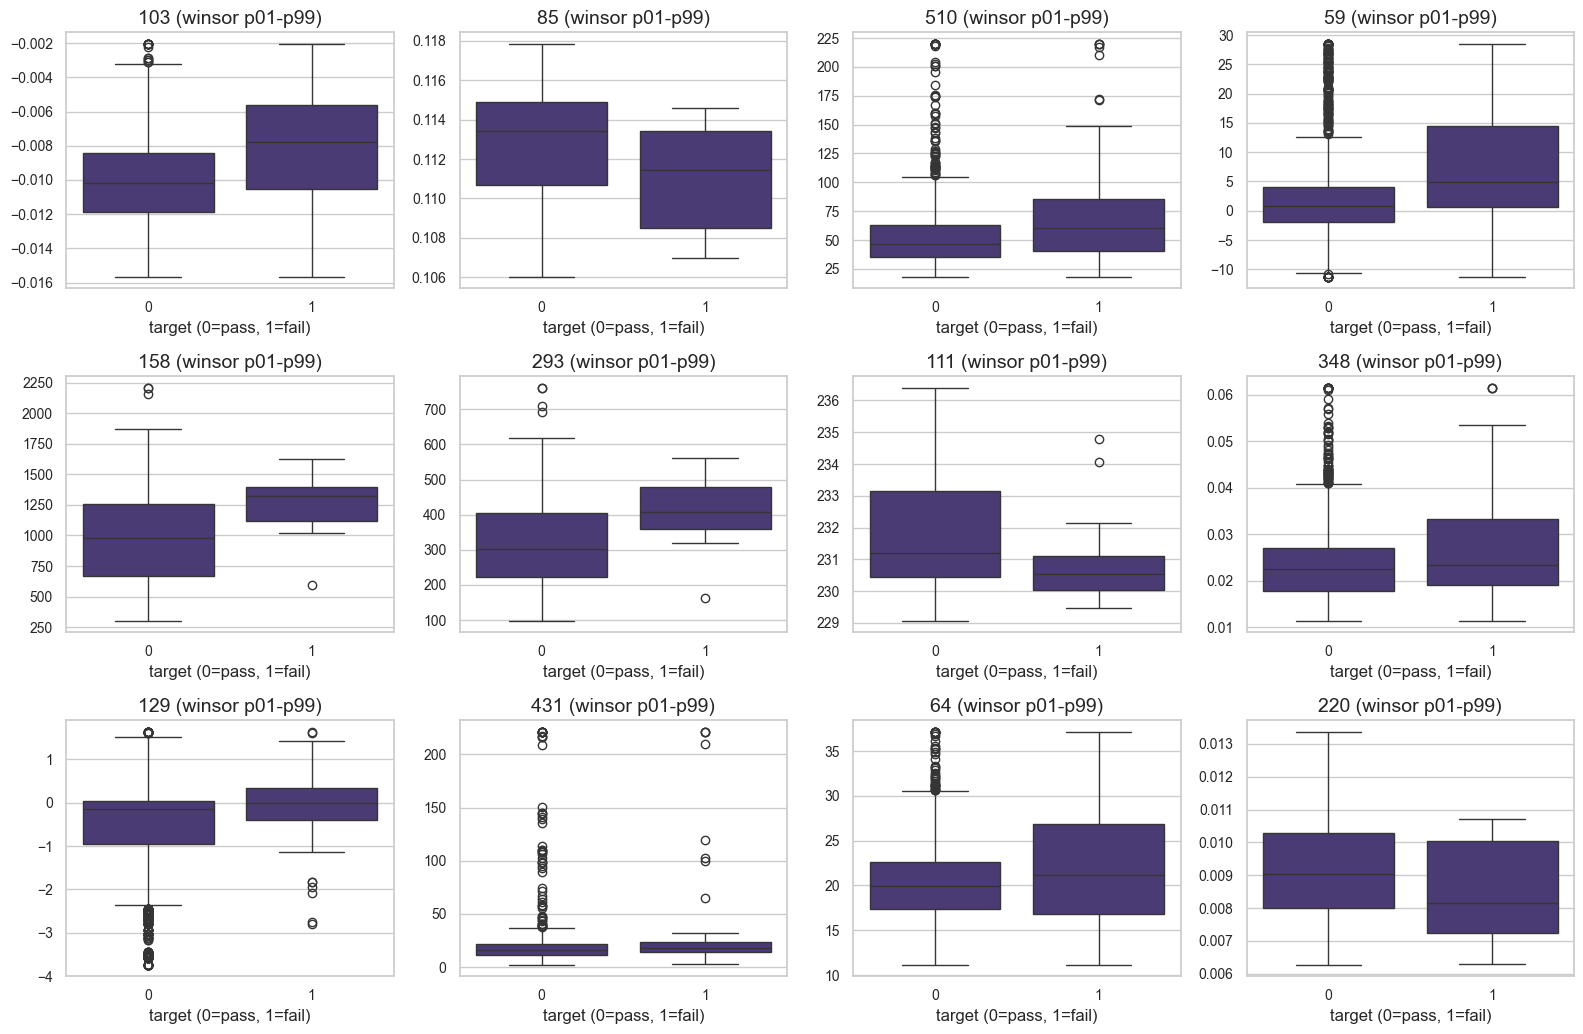


Probe holdout PR-AUC (fixed thr=0.5): 0.1196
Probe holdout recall (fixed thr=0.5): 0.2857

Recall by row-missingness subgroup (probe model, holdout, thr=0.5):


rowmiss_group      n  fails  fail_rate    recall
0  row_missing_pct: bottom 75%  223.0   15.0   0.067265  0.266667
1     row_missing_pct: top 25%   91.0    6.0   0.065934  0.333333


Recall by time subgroup (probe model, holdout, thr=0.5):


time_group      n  fails  fail_rate  recall
0      early  157.0   16.0   0.101911    0.25
1       late  157.0    5.0   0.031847    0.40


Recall by 103 subgroup (probe model, holdout, thr=0.5):


sensor_group      n  fails  fail_rate    recall
0          low  158.0    7.0   0.044304  0.285714
1         high  156.0   14.0   0.089744  0.285714

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, average_precision_score

TARGET_RAW = "Pass/Fail"   # -1 pass, 1 fail
TIME_COL   = "Time"

df_work = df.copy()

# -------------------------
# 0) Target cleanup + sanity
# -------------------------
if "y" not in df_work.columns:
    df_work["y"] = (df_work[TARGET_RAW] == 1).astype(int)

print("Rows:", len(df_work))
print("Fail rate:", df_work["y"].mean().round(4))
print(df_work["y"].value_counts().rename(index={0:"pass(0)", 1:"fail(1)"}))

# -------------------------
# 1) Parse Time + derive (for audits, not necessarily modeling yet)
# -------------------------
if TIME_COL in df_work.columns:
    df_work[TIME_COL] = pd.to_datetime(df_work[TIME_COL], errors="coerce")
    df_work["time_minutes_since_start"] = (
        (df_work[TIME_COL] - df_work[TIME_COL].min()).dt.total_seconds() / 60.0
    )
    df_work["time_dayofweek"] = df_work[TIME_COL].dt.dayofweek
    df_work["time_hour"] = df_work[TIME_COL].dt.hour

# -------------------------
# 2) Sensor matrix (numeric only)
# -------------------------
drop_cols = [TARGET_RAW, "y"]
if TIME_COL in df_work.columns:
    drop_cols.append(TIME_COL)

X_sensors = df_work.drop(columns=drop_cols, errors="ignore").apply(pd.to_numeric, errors="coerce")
y_all = df_work["y"].astype(int)

print("\nSensor cols:", X_sensors.shape[1])

# ============================================================
# A) Missingness summary (per-column + per-row)
# ============================================================
col_missing = X_sensors.isna().mean().sort_values(ascending=False)
row_missing = X_sensors.isna().mean(axis=1)

print("\nTop 15 missingness columns:")
display(col_missing.head(15))

print("\nRow missingness summary:")
display(row_missing.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95]))

# Plot: missingness distribution per column
plt.figure(figsize=(7,4))
plt.hist(col_missing.values, bins=30)
plt.title("Feature Missingness (per column)")
plt.xlabel("Fraction missing")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('results/sensor_boxplots.png', dpi=300, bbox_inches='tight')
print('  → Saved to results/sensor_boxplots.png')
plt.show()

# Plot: row missingness distribution
plt.figure(figsize=(7,4))
plt.hist(row_missing.values, bins=30)
plt.title("Row Missingness (per row)")
plt.xlabel("Fraction missing")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('results/sensor_boxplots.png', dpi=300, bbox_inches='tight')
print('  → Saved to results/sensor_boxplots.png')
plt.show()

# Fail rate by row-missingness bin (is missingness informative?)
tmp = pd.DataFrame({"row_missing_pct": row_missing, "y": y_all})
tmp["missing_bin"] = pd.qcut(tmp["row_missing_pct"], q=5, duplicates="drop")
miss_bin = (tmp.groupby("missing_bin")["y"]
              .agg(["count","mean"])
              .rename(columns={"mean":"fail_rate"}))
miss_bin["fail_rate_pct"] = (100*miss_bin["fail_rate"]).round(2)

print("\nFail rate by row-missingness quintile:")
display(miss_bin)

# ============================================================
# B) Constant / near-constant summary (quick hygiene)
# ============================================================
col_std = X_sensors.std(skipna=True)
n_const = int((col_std == 0).sum())
print(f"\nConstant features (std=0): {n_const}")

# Optional: show top 10 lowest std (excluding true zeros)
low_std = col_std[col_std > 0].sort_values().head(10)
print("\nLowest non-zero std features:")
display(low_std)

# ============================================================
# C) Top-12 sensors by effect size (Cohen's d) + boxplots
#    (compute on TRAIN only to avoid peeking)
# ============================================================
X_train, X_hold, y_train, y_hold = train_test_split(
    X_sensors, y_all, test_size=0.20, random_state=42, stratify=y_all
)

def cohen_d(x0, x1):
    x0 = x0.dropna()
    x1 = x1.dropna()
    if len(x0) < 5 or len(x1) < 5:
        return np.nan
    s0 = x0.std(ddof=1)
    s1 = x1.std(ddof=1)
    sp = np.sqrt(((len(x0)-1)*s0*s0 + (len(x1)-1)*s1*s1) / (len(x0)+len(x1)-2))
    if sp == 0 or np.isnan(sp):
        return 0.0
    return (x1.mean() - x0.mean()) / sp  # fail - pass

effects = []
for col in X_train.columns:
    d = cohen_d(X_train.loc[y_train==0, col], X_train.loc[y_train==1, col])
    effects.append((col, d, np.abs(d)))

rank_df = (pd.DataFrame(effects, columns=["feature","cohen_d","abs_cohen_d"])
             .dropna()
             .sort_values("abs_cohen_d", ascending=False))

top_feats = rank_df.head(12)["feature"].tolist()
print("\nTop-12 by |Cohen's d| (train-only):")
display(rank_df.head(12))

def winsorize_series(s, p_low=0.01, p_high=0.99):
    lo = s.quantile(p_low)
    hi = s.quantile(p_high)
    return s.clip(lo, hi)

# Long-form for seaborn boxplots
long_rows = []
for f in top_feats:
    long_rows.append(pd.DataFrame({
        "feature": f,
        "value": winsorize_series(X_train[f]),
        "target": y_train.values
    }))
long_df = pd.concat(long_rows, ignore_index=True)

n = len(top_feats)
ncols = 4
nrows = int(np.ceil(n / ncols))
plt.figure(figsize=(16, 3.5*nrows))

for i, f in enumerate(top_feats, 1):
    ax = plt.subplot(nrows, ncols, i)
    sub = long_df[long_df["feature"] == f]
    sns.boxplot(data=sub, x="target", y="value", ax=ax)
    ax.set_title(f"{f} (winsor p01-p99)")
    ax.set_xlabel("target (0=pass, 1=fail)")
    ax.set_ylabel("")
plt.tight_layout()
plt.savefig('results/sensor_boxplots.png', dpi=300, bbox_inches='tight')
print('  → Saved to results/sensor_boxplots.png')
plt.show()

# ============================================================
# D) Quick subgroup sanity checks
#    - fail-rate by subgroup (descriptive)
#    - recall by subgroup using a simple provisional model
#      (NOT threshold tuned on holdout; use fixed 0.5 here)
# ============================================================
# Build lightweight provisional model (train-only fit)
probe_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear"))
])

probe_model.fit(X_train, y_train)
p_hold = probe_model.predict_proba(X_hold)[:, 1]
yhat_hold = (p_hold >= 0.5).astype(int)

print("\nProbe holdout PR-AUC (fixed thr=0.5):", round(average_precision_score(y_hold, p_hold), 4))
print("Probe holdout recall (fixed thr=0.5):", round(recall_score(y_hold, yhat_hold, zero_division=0), 4))

audit = pd.DataFrame({
    "y": y_hold.reset_index(drop=True),
    "pred": yhat_hold,
    "row_missing_pct": X_hold.isna().mean(axis=1).reset_index(drop=True)
})

# Subgroup 1: high vs low row-missingness
q75 = audit["row_missing_pct"].quantile(0.75)
audit["rowmiss_group"] = np.where(audit["row_missing_pct"] >= q75, "row_missing_pct: top 25%", "row_missing_pct: bottom 75%")

sub1 = (audit.groupby("rowmiss_group")
             .apply(lambda g: pd.Series({
                 "n": len(g),
                 "fails": int(g["y"].sum()),
                 "fail_rate": g["y"].mean(),
                 "recall": recall_score(g["y"], g["pred"], zero_division=0)
             }))
             .reset_index())

print("\nRecall by row-missingness subgroup (probe model, holdout, thr=0.5):")
display(sub1)

# Subgroup 2 (optional): time bins (early vs late) if time_minutes_since_start exists
if "time_minutes_since_start" in df_work.columns:
    hold_idx = X_hold.index
    t_hold = df_work.loc[hold_idx, "time_minutes_since_start"].reset_index(drop=True)
    audit["time_minutes_since_start"] = t_hold
    audit["time_group"] = pd.qcut(audit["time_minutes_since_start"], q=2, labels=["early","late"])

    sub2 = (audit.groupby("time_group")
                 .apply(lambda g: pd.Series({
                     "n": len(g),
                     "fails": int(g["y"].sum()),
                     "fail_rate": g["y"].mean(),
                     "recall": recall_score(g["y"], g["pred"], zero_division=0)
                 }))
                 .reset_index())
    print("\nRecall by time subgroup (probe model, holdout, thr=0.5):")
    display(sub2)

# Subgroup 3: one “top sensor” quantiles (use top_feats[0] if exists)
top_sensor = top_feats[0] if len(top_feats) else None
if top_sensor is not None and top_sensor in X_hold.columns:
    s = X_hold[top_sensor].reset_index(drop=True)
    audit["top_sensor"] = s
    # Use qcut with duplicates handling
    audit["sensor_group"] = pd.qcut(audit["top_sensor"], q=2, duplicates="drop", labels=["low","high"])

    sub3 = (audit.groupby("sensor_group")
                 .apply(lambda g: pd.Series({
                     "n": len(g),
                     "fails": int(g["y"].sum()),
                     "fail_rate": g["y"].mean(),
                     "recall": recall_score(g["y"], g["pred"], zero_division=0)
                 }))
                 .reset_index())
    print(f"\nRecall by {top_sensor} subgroup (probe model, holdout, thr=0.5):")
    display(sub3)


Step A — Baseline with OOF threshold tuning (recall-focused)

In [27]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    average_precision_score, roc_auc_score
)

Xtr = X_train_final
ytr = y_train.values if hasattr(y_train, "values") else np.array(y_train)

# -------------------------
# Model (baseline)
# -------------------------
base_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # safe even if already imputed
    ("scaler", StandardScaler(with_mean=False)),    # with_mean=False safe if sparse-like; fine for dense too
    ("clf", LogisticRegression(
        max_iter=4000,
        solver="liblinear",
        class_weight="balanced"
    ))
])

# -------------------------
# OOF prediction
# -------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(ytr), dtype=float)

for fold, (tr_idx, va_idx) in enumerate(skf.split(Xtr, ytr), start=1):
    X_fold_tr, X_fold_va = Xtr.iloc[tr_idx], Xtr.iloc[va_idx]
    y_fold_tr, y_fold_va = ytr[tr_idx], ytr[va_idx]

    base_model.fit(X_fold_tr, y_fold_tr)
    oof[va_idx] = base_model.predict_proba(X_fold_va)[:, 1]

print("OOF PR-AUC:", round(average_precision_score(ytr, oof), 4))
print("OOF ROC-AUC:", round(roc_auc_score(ytr, oof), 4))

# -------------------------
# Threshold search (favor recall using F-beta)
# -------------------------
def best_threshold_pr(y_true, p, beta=2.0, min_precision=None):
    thresholds = np.linspace(0.01, 0.99, 99)
    best = {"thr": 0.5, "p": 0.0, "r": 0.0, "fb": -1}

    for thr in thresholds:
        yhat = (p >= thr).astype(int)
        prec = precision_score(y_true, yhat, zero_division=0)
        rec  = recall_score(y_true, yhat, zero_division=0)

        if min_precision is not None and prec < min_precision:
            continue

        denom = (beta**2 * prec + rec)
        fb = 0.0 if denom == 0 else (1 + beta**2) * (prec * rec) / denom

        if fb > best["fb"]:
            best = {"thr": thr, "p": prec, "r": rec, "fb": fb}

    return best["thr"], best["p"], best["r"], best["fb"]

best_thr, oof_p, oof_r, oof_f2 = best_threshold_pr(ytr, oof, beta=2.0, min_precision=None)
print(f"Best OOF threshold (F2): {best_thr:.3f} | precision={oof_p:.3f} recall={oof_r:.3f} F2={oof_f2:.3f}")


OOF PR-AUC: 0.1192
OOF ROC-AUC: 0.6151
Best OOF threshold (F2): 0.010 | precision=0.108 recall=0.518 F2=0.295


In [28]:
from sklearn.metrics import classification_report

# Fit on full training
base_model.fit(X_train_final, ytr)

# Evaluate on holdout using the OOF-selected threshold
p_hold = base_model.predict_proba(X_hold_final)[:, 1]
yhat_hold = (p_hold >= best_thr).astype(int)

print("Holdout PR-AUC:", round(average_precision_score(y_holdout, p_hold), 4))
print("Holdout ROC-AUC:", round(roc_auc_score(y_holdout, p_hold), 4))
print("Holdout Precision:", round(precision_score(y_holdout, yhat_hold, zero_division=0), 4))
print("Holdout Recall:", round(recall_score(y_holdout, yhat_hold, zero_division=0), 4))
print("Holdout F1:", round(f1_score(y_holdout, yhat_hold, zero_division=0), 4))
print("\nClassification report:")
print(classification_report(y_holdout, yhat_hold, digits=4, zero_division=0))


Holdout PR-AUC: 0.1352
Holdout ROC-AUC: 0.5825
Holdout Precision: 0.08
Holdout Recall: 0.381
Holdout F1: 0.1322

Classification report:
              precision    recall  f1-score   support

           0     0.9393    0.6860    0.7929       293
           1     0.0800    0.3810    0.1322        21

    accuracy                         0.6656       314
   macro avg     0.5096    0.5335    0.4626       314
weighted avg     0.8818    0.6656    0.7487       314



In [29]:
best_thr, oof_p, oof_r, oof_f2 = best_threshold_pr(
    ytr, oof, beta=2.0, min_precision=0.15  # try 0.10, 0.15, 0.20
)
print(f"Best OOF threshold (F2, min precision=0.15): {best_thr:.3f} | "
      f"precision={oof_p:.3f} recall={oof_r:.3f} F2={oof_f2:.3f}")


Best OOF threshold (F2, min precision=0.15): 0.790 | precision=0.164 recall=0.229 F2=0.212


In [30]:
# Fit on full train
base_model.fit(X_train_final, ytr)

clf = base_model.named_steps["clf"]
coefs = pd.Series(clf.coef_.ravel(), index=X_train_final.columns)

top_pos = coefs.sort_values(ascending=False).head(20)  # pushes toward fail (1)
top_neg = coefs.sort_values().head(20)                 # pushes toward pass (0)

print("Top drivers toward FAIL (positive coef):")
display(top_pos.to_frame("coef"))

print("Top drivers toward PASS (negative coef):")
display(top_neg.to_frame("coef"))


Top drivers toward FAIL (positive coef):


coef
59   2.426278
172  1.602700
25   1.515894
197  1.262974
205  1.257726
129  1.219530
61   1.121260
133  1.065159
56   1.005900
21   0.998735
64   0.939433
75   0.905030
500  0.890052
113  0.879900
29   0.839171
565  0.835171
114  0.832399
60   0.830175
348  0.821679
471  0.820347

Top drivers toward PASS (negative coef):


coef
164             -1.751405
132             -1.698152
124             -1.528342
214             -1.424256
573             -1.351921
row_missing_pct -1.345296
251             -1.271896
41              -1.269076
30              -1.262899
78              -1.088433
94              -1.078530
563             -1.064929
145             -1.037379
196             -1.028015
67              -1.018392
155             -1.016750
221             -0.907453
562             -0.901481
154             -0.896853
146             -0.896380

In [31]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_fscore_support, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def best_threshold_pr(y_true, prob, beta=2.0, min_precision=None):
    """
    Choose threshold that maximizes F-beta on OOF probs.
    Optionally require precision >= min_precision.
    """
    y_true = np.asarray(y_true)
    prob = np.asarray(prob)

    thresholds = np.unique(np.quantile(prob, np.linspace(0.01, 0.99, 200)))
    best = {"thr": 0.5, "p": 0.0, "r": 0.0, "f": -1}

    for thr in thresholds:
        pred = (prob >= thr).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(y_true, pred, average="binary", zero_division=0)

        # F-beta
        if (p + r) == 0:
            fbeta = 0.0
        else:
            fbeta = (1 + beta**2) * (p * r) / ((beta**2) * p + r)

        if min_precision is not None and p < min_precision:
            continue

        if fbeta > best["f"]:
            best = {"thr": float(thr), "p": float(p), "r": float(r), "f": float(fbeta)}

    return best

# ----------------------------
# 1) Baseline model (weighted LR)
# ----------------------------
base_model = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        max_iter=5000,
        solver="liblinear",
        class_weight="balanced"  # key for imbalance
    ))
])

# ----------------------------
# 2) OOF predictions
# ----------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(y_train), dtype=float)

Xtr = X_train_final.reset_index(drop=True)
ytr = pd.Series(y_train).reset_index(drop=True)

for fold, (tr_idx, va_idx) in enumerate(skf.split(Xtr, ytr), 1):
    X_fold_tr, y_fold_tr = Xtr.iloc[tr_idx], ytr.iloc[tr_idx]
    X_fold_va, y_fold_va = Xtr.iloc[va_idx], ytr.iloc[va_idx]

    base_model.fit(X_fold_tr, y_fold_tr)
    oof[va_idx] = base_model.predict_proba(X_fold_va)[:, 1]

print("OOF PR-AUC:", round(average_precision_score(ytr, oof), 4))
print("OOF ROC-AUC:", round(roc_auc_score(ytr, oof), 4))

# ----------------------------
# 3) Choose threshold for recall focus
# ----------------------------
best = best_threshold_pr(ytr, oof, beta=2.0, min_precision=None)  # set min_precision=0.15 if you want
print(f"Best OOF threshold (F2): {best['thr']:.3f} | precision={best['p']:.3f} recall={best['r']:.3f} F2={best['f']:.3f}")

# ----------------------------
# 4) Train full model, evaluate holdout
# ----------------------------
base_model.fit(Xtr, ytr)
hold_prob = base_model.predict_proba(X_hold_final)[:, 1]
hold_pred = (hold_prob >= best["thr"]).astype(int)

print("Holdout PR-AUC:", round(average_precision_score(y_holdout, hold_prob), 4))
print("Holdout ROC-AUC:", round(roc_auc_score(y_holdout, hold_prob), 4))

p, r, f1, _ = precision_recall_fscore_support(y_holdout, hold_pred, average="binary", zero_division=0)
print("Holdout Precision:", round(p, 4))
print("Holdout Recall   :", round(r, 4))
print("Holdout F1       :", round(f1, 4))
print("\nClassification report:\n", classification_report(y_holdout, hold_pred, zero_division=0))


OOF PR-AUC: 0.1161
OOF ROC-AUC: 0.6143
Best OOF threshold (F2): 0.048 | precision=0.111 recall=0.518 F2=0.298
Holdout PR-AUC: 0.133
Holdout ROC-AUC: 0.5922
Holdout Precision: 0.0909
Holdout Recall   : 0.381
Holdout F1       : 0.1468

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.73      0.82       293
           1       0.09      0.38      0.15        21

    accuracy                           0.70       314
   macro avg       0.52      0.55      0.48       314
weighted avg       0.89      0.70      0.78       314



In [32]:
import pandas as pd
import numpy as np

# Pull fitted LR inside the pipeline
clf = base_model.named_steps["clf"]
coefs = clf.coef_.ravel()

feat_imp = pd.DataFrame({
    "feature": X_train_final.columns,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

print("Top drivers toward FAIL (positive coef):")
print(feat_imp.sort_values("coef", ascending=False).head(20)[["feature","coef"]])

print("\nTop drivers toward PASS (negative coef):")
print(feat_imp.sort_values("coef", ascending=True).head(20)[["feature","coef"]])


Top drivers toward FAIL (positive coef):
    feature      coef
52       59  2.137074
23       25  1.521752
146     172  1.281952
168     205  1.255288
49       56  1.233391
161     197  1.201257
54       61  1.156467
111     129  0.993040
115     133  0.881503
53       60  0.846301
57       64  0.828570
260     565  0.827848
207     348  0.813218
224     471  0.798799
19       21  0.786781
142     168  0.772193
96      113  0.742177
97      114  0.717228
40       45  0.692819
67       75  0.692050

Top drivers toward PASS (negative coef):
             feature      coef
139              164 -1.566127
107              124 -1.373078
114              132 -1.340795
271  row_missing_pct -1.182724
175              214 -1.168923
265              573 -1.103904
27                30 -1.045456
60                67 -1.008970
193              251 -1.004844
37                41 -0.994137
160              196 -0.975783
85                94 -0.921323
70                78 -0.891677
258              563 

In [33]:
from sklearn.metrics import precision_recall_curve
import numpy as np

def pick_threshold_with_precision_floor(y_true, prob, min_precision=0.15):
    prec, rec, thr = precision_recall_curve(y_true, prob)
    # thr has length len(prec)-1; align by skipping the last precision/recall point
    prec, rec = prec[:-1], rec[:-1]

    ok = prec >= min_precision
    if not np.any(ok):
        return None, None, None  # no threshold meets the precision floor

    # among thresholds meeting precision, pick the one with best recall (or best F2)
    idx = np.argmax(rec[ok])
    thr_ok = thr[ok][idx]
    return float(thr_ok), float(prec[ok][idx]), float(rec[ok][idx])

thr_p15, p15, r15 = pick_threshold_with_precision_floor(y_holdout, hold_prob, min_precision=0.15)
print("Best threshold with precision>=0.15:", thr_p15, "precision:", p15, "recall:", r15)


Best threshold with precision>=0.15: 0.8538285230390664 precision: 0.15384615384615385 recall: 0.19047619047619047


In [34]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, classification_report, precision_recall_fscore_support

# ---- choose your threshold policy ----
USE_PRECISION_FLOOR = True
MIN_PRECISION = 0.15     # adjust (0.10, 0.15, 0.20)
BETA = 2.0               # recall-focused

def best_threshold_fbeta(y_true, prob, beta=2.0, min_precision=None):
    y_true = np.asarray(y_true)
    prob = np.asarray(prob)

    thresholds = np.unique(np.quantile(prob, np.linspace(0.01, 0.99, 200)))
    best = {"thr": 0.5, "p": 0.0, "r": 0.0, "f": -1}

    for thr in thresholds:
        pred = (prob >= thr).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(y_true, pred, average="binary", zero_division=0)

        if (p + r) == 0:
            fbeta = 0.0
        else:
            fbeta = (1 + beta**2) * (p * r) / ((beta**2) * p + r)

        if min_precision is not None and p < min_precision:
            continue

        if fbeta > best["f"]:
            best = {"thr": float(thr), "p": float(p), "r": float(r), "f": float(fbeta)}

    return best

def predicted_positive_rate(prob, thr):
    return float((prob >= thr).mean())

# ------------------------------------------
# 0) data
# ------------------------------------------
Xtr = X_train_final.reset_index(drop=True)
ytr = pd.Series(y_train).reset_index(drop=True)

Xho = X_hold_final.reset_index(drop=True)
yho = pd.Series(y_holdout).reset_index(drop=True)

# ------------------------------------------
# 1) LightGBM model
# ------------------------------------------
try:
    import lightgbm as lgb
except ImportError as e:
    raise ImportError("Install LightGBM: pip install lightgbm") from e

pos = ytr.sum()
neg = len(ytr) - pos
scale_pos_weight = neg / max(pos, 1)

params = dict(
    n_estimators=800,
    learning_rate=0.03,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_samples=30,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

# ------------------------------------------
# 2) OOF predictions
# ------------------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(ytr), dtype=float)

fold_rows = []
for fold, (tr_idx, va_idx) in enumerate(skf.split(Xtr, ytr), 1):
    X_fold_tr, y_fold_tr = Xtr.iloc[tr_idx], ytr.iloc[tr_idx]
    X_fold_va, y_fold_va = Xtr.iloc[va_idx], ytr.iloc[va_idx]

    model = lgb.LGBMClassifier(**params)
    model.fit(X_fold_tr, y_fold_tr)

    prob_va = model.predict_proba(X_fold_va)[:, 1]
    oof[va_idx] = prob_va

    fold_rows.append({
        "fold": fold,
        "pr_auc": average_precision_score(y_fold_va, prob_va),
        "roc_auc": roc_auc_score(y_fold_va, prob_va),
        "fail_rate_val": float(y_fold_va.mean()),
        "n_val": len(y_fold_va),
    })

fold_df = pd.DataFrame(fold_rows)
print("OOF PR-AUC:", round(average_precision_score(ytr, oof), 4))
print("OOF ROC-AUC:", round(roc_auc_score(ytr, oof), 4))
print("\nPer-fold summary:\n", fold_df)

# ------------------------------------------
# 3) Pick threshold from OOF
# ------------------------------------------
min_p = MIN_PRECISION if USE_PRECISION_FLOOR else None
best = best_threshold_fbeta(ytr, oof, beta=BETA, min_precision=min_p)
thr = best["thr"]
print(f"\nBest OOF threshold (F{BETA}, min_precision={min_p}): {thr:.3f} | precision={best['p']:.3f} recall={best['r']:.3f} F={best['f']:.3f}")
print("OOF predicted-positive rate:", round(predicted_positive_rate(oof, thr), 4))

# ------------------------------------------
# 4) Fit full model + evaluate holdout
# ------------------------------------------
final_model = lgb.LGBMClassifier(**params)
final_model.fit(Xtr, ytr)

hold_prob = final_model.predict_proba(Xho)[:, 1]
hold_pred = (hold_prob >= thr).astype(int)

print("\nHoldout PR-AUC:", round(average_precision_score(yho, hold_prob), 4))
print("Holdout ROC-AUC:", round(roc_auc_score(yho, hold_prob), 4))

p, r, f1, _ = precision_recall_fscore_support(yho, hold_pred, average="binary", zero_division=0)
print("Holdout Precision:", round(p, 4))
print("Holdout Recall   :", round(r, 4))
print("Holdout F1       :", round(f1, 4))
print("Holdout predicted-positive rate:", round(predicted_positive_rate(hold_prob, thr), 4))

print("\nClassification report:\n", classification_report(yho, hold_pred, zero_division=0))

# ------------------------------------------
# 5) Feature importance
# ------------------------------------------
imp = pd.DataFrame({
    "feature": Xtr.columns,
    "importance": final_model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop 25 feature importances:\n", imp.head(25))


[LightGBM] [Info] Number of positive: 66, number of negative: 936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58966
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 305
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065868 -> initscore=-2.651961
[LightGBM] [Info] Start training from score -2.651961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [35]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_fscore_support, classification_report,
    confusion_matrix
)

# ----------------------------------------------------
# Inputs: you already have these
# X_train_final, y_train
# X_hold_final,  y_holdout
# ----------------------------------------------------
Xtr = X_train_final.reset_index(drop=True).copy()
ytr = pd.Series(y_train).reset_index(drop=True).astype(int)

Xho = X_hold_final.reset_index(drop=True).copy()
yho = pd.Series(y_holdout).reset_index(drop=True).astype(int)

# ----------------------------------------------------
# Threshold selection (F-beta) with optional precision floor
# ----------------------------------------------------
def best_threshold_fbeta(y_true, prob, beta=2.0, min_precision=None):
    y_true = np.asarray(y_true)
    prob = np.asarray(prob)

    # candidate thresholds from quantiles (stable for imbalanced probs)
    thresholds = np.unique(np.quantile(prob, np.linspace(0.01, 0.99, 300)))
    best = {"thr": 0.5, "p": 0.0, "r": 0.0, "fbeta": -1.0}

    for thr in thresholds:
        pred = (prob >= thr).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true, pred, average="binary", zero_division=0
        )

        if (p == 0 and r == 0):
            fbeta = 0.0
        else:
            fbeta = (1 + beta**2) * (p * r) / ((beta**2) * p + r)

        if (min_precision is not None) and (p < min_precision):
            continue

        if fbeta > best["fbeta"]:
            best = {"thr": float(thr), "p": float(p), "r": float(r), "fbeta": float(fbeta)}

    return best

def pos_rate(prob, thr):
    return float((np.asarray(prob) >= thr).mean())

# ----------------------------------------------------
# Model: LR + scaling
# - class_weight='balanced' is the simplest imbalance technique for baseline
# ----------------------------------------------------
lr = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2",
        solver="liblinear",
        class_weight="balanced",
        max_iter=2000,
        random_state=42
    ))
])

# ----------------------------------------------------
# 1) OOF probabilities (TRAIN only)
# ----------------------------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(ytr), dtype=float)

fold_rows = []
for fold, (tr_idx, va_idx) in enumerate(skf.split(Xtr, ytr), 1):
    X_fold_tr, y_fold_tr = Xtr.iloc[tr_idx], ytr.iloc[tr_idx]
    X_fold_va, y_fold_va = Xtr.iloc[va_idx], ytr.iloc[va_idx]

    lr.fit(X_fold_tr, y_fold_tr)
    prob_va = lr.predict_proba(X_fold_va)[:, 1]
    oof[va_idx] = prob_va

    fold_rows.append({
        "fold": fold,
        "pr_auc": average_precision_score(y_fold_va, prob_va),
        "roc_auc": roc_auc_score(y_fold_va, prob_va),
        "fail_rate_val": float(y_fold_va.mean()),
        "n_val": len(y_fold_va),
    })

fold_df = pd.DataFrame(fold_rows)
print("OOF PR-AUC:", round(average_precision_score(ytr, oof), 4))
print("OOF ROC-AUC:", round(roc_auc_score(ytr, oof), 4))
print("\nPer-fold summary:\n", fold_df)

# ----------------------------------------------------
# 2) Choose threshold from OOF
#    - set MIN_PRECISION if you want fewer false alarms
# ----------------------------------------------------
BETA = 2.0
MIN_PRECISION = None    # e.g., 0.15 if you want a precision floor

best = best_threshold_fbeta(ytr, oof, beta=BETA, min_precision=MIN_PRECISION)
thr = best["thr"]
print(f"\nBest OOF threshold (F{BETA}, min_precision={MIN_PRECISION}): "
      f"{thr:.3f} | precision={best['p']:.3f} recall={best['r']:.3f} F{BETA}={best['fbeta']:.3f}")
print("OOF predicted-positive rate:", round(pos_rate(oof, thr), 4))

# ----------------------------------------------------
# 3) Fit final model on ALL train and evaluate on HOLDOUT
# ----------------------------------------------------
lr.fit(Xtr, ytr)
hold_prob = lr.predict_proba(Xho)[:, 1]
hold_pred = (hold_prob >= thr).astype(int)

print("\nHoldout PR-AUC:", round(average_precision_score(yho, hold_prob), 4))
print("Holdout ROC-AUC:", round(roc_auc_score(yho, hold_prob), 4))

p, r, f1, _ = precision_recall_fscore_support(yho, hold_pred, average="binary", zero_division=0)
print("Holdout Precision:", round(p, 4))
print("Holdout Recall   :", round(r, 4))
print("Holdout F1       :", round(f1, 4))
print("Holdout predicted-positive rate:", round(pos_rate(hold_prob, thr), 4))

print("\nConfusion matrix [tn fp; fn tp]:\n", confusion_matrix(yho, hold_pred))
print("\nClassification report:\n", classification_report(yho, hold_pred, zero_division=0))

# ----------------------------------------------------
# 4) “Top drivers” for LR (coefs)
# ----------------------------------------------------
feat_names = Xtr.columns.to_list()
coef = lr.named_steps["clf"].coef_.ravel()

coef_df = pd.DataFrame({"feature": feat_names, "coef": coef}).sort_values("coef", ascending=False)

print("\nTop drivers toward FAIL (positive coef):")
print(coef_df.head(20).to_string(index=False))

print("\nTop drivers toward PASS (negative coef):")
print(coef_df.tail(20).sort_values("coef").to_string(index=False))


OOF PR-AUC: 0.1161
OOF ROC-AUC: 0.6143

Per-fold summary:
    fold    pr_auc   roc_auc  fail_rate_val  n_val
0     1  0.089983  0.560080       0.067729    251
1     2  0.227154  0.695073       0.067729    251
2     3  0.144345  0.631222       0.067729    251
3     4  0.075945  0.514690       0.064000    250
4     5  0.205256  0.661592       0.064000    250

Best OOF threshold (F2.0, min_precision=None): 0.047 | precision=0.110 recall=0.518 F2.0=0.297
OOF predicted-positive rate: 0.3121

Holdout PR-AUC: 0.133
Holdout ROC-AUC: 0.5922
Holdout Precision: 0.0909
Holdout Recall   : 0.381
Holdout F1       : 0.1468
Holdout predicted-positive rate: 0.2803

Confusion matrix [tn fp; fn tp]:
 [[213  80]
 [ 13   8]]

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.73      0.82       293
           1       0.09      0.38      0.15        21

    accuracy                           0.70       314
   macro avg       0.52      0.55      0.48 

In [36]:
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_fscore_support, confusion_matrix, classification_report
)

def compute_metrics(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    pr_auc = average_precision_score(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    pos_rate = y_pred.mean()
    return {
        "pr_auc": pr_auc,
        "roc_auc": roc_auc,
        "precision": p,
        "recall": r,
        "f1": f1,
        "pos_rate": pos_rate
    }

def best_threshold_pr(y_true, y_prob, beta=2.0, min_precision=None, max_pos_rate=None, n_grid=400):
    """
    Pick threshold that maximizes F-beta under optional constraints:
      - min_precision: require precision >= this
      - max_pos_rate: require predicted-positive rate <= this
    """
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob)

    # grid over unique-ish probabilities (stable), but cap to n_grid for speed
    qs = np.linspace(0.0, 1.0, n_grid)
    thr_grid = np.quantile(y_prob, qs)
    thr_grid = np.unique(thr_grid)

    best = {"thr": 0.5, "precision": 0.0, "recall": 0.0, "fb": -1.0, "pos_rate": 0.0}

    for thr in thr_grid:
        y_pred = (y_prob >= thr).astype(int)
        pos_rate = y_pred.mean()

        if max_pos_rate is not None and pos_rate > max_pos_rate:
            continue

        p, r, _, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
        if min_precision is not None and p < min_precision:
            continue

        if p == 0 and r == 0:
            fb = 0.0
        else:
            b2 = beta * beta
            fb = (1 + b2) * (p * r) / (b2 * p + r + 1e-12)

        if fb > best["fb"]:
            best = {"thr": float(thr), "precision": float(p), "recall": float(r), "fb": float(fb), "pos_rate": float(pos_rate)}

    return best

def get_feature_importance(model, feature_names):
    """
    Returns pd.Series of feature importances.
    Supports: feature_importances_, coef_.
    """
    if hasattr(model, "feature_importances_"):
        imp = np.asarray(model.feature_importances_, dtype=float)
        return pd.Series(imp, index=feature_names).sort_values(ascending=False)
    if hasattr(model, "coef_"):
        coef = np.asarray(model.coef_).ravel()
        return pd.Series(np.abs(coef), index=feature_names).sort_values(ascending=False)
    raise ValueError("Model has no feature_importances_ or coef_")

def run_oof_cv(model_factory, X, y, n_splits=5, random_state=42):
    """
    Standard OOF: fit model per fold, store val probabilities.
    Returns oof_probs and per-fold metrics dataframe.
    """
    X = X.reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True).astype(int)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof = np.zeros(len(y), dtype=float)
    fold_rows = []
    fit_seconds = 0.0

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        model = model_factory()
        t0 = time.time()
        model.fit(X_tr, y_tr)
        fit_seconds += (time.time() - t0)

        oof[va_idx] = model.predict_proba(X_va)[:, 1]

        fold_rows.append({
            "fold": fold,
            "pr_auc": average_precision_score(y_va, oof[va_idx]),
            "roc_auc": roc_auc_score(y_va, oof[va_idx]),
            "fail_rate_val": float(y_va.mean()),
            "n_val": len(va_idx)
        })

    fold_df = pd.DataFrame(fold_rows)
    return oof, fold_df, fit_seconds


In [37]:
def run_oof_cv_topk(model_factory, X, y, topk=50, n_splits=5, random_state=42):
    """
    Fair top-K evaluation:
      For each fold:
        1) fit on fold-train
        2) rank features from that fold-train model
        3) refit using only top-K features
        4) predict on fold-val
    """
    X = X.reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True).astype(int)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof = np.zeros(len(y), dtype=float)
    fold_rows = []
    fit_seconds = 0.0

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        # 1) initial fit
        m0 = model_factory()
        t0 = time.time()
        m0.fit(X_tr, y_tr)
        fit_seconds += (time.time() - t0)

        # 2) rank features from fold-train
        imp = get_feature_importance(m0, X_tr.columns)
        top_feats = imp.head(topk).index.tolist()

        # 3) refit on top-K
        m1 = model_factory()
        t1 = time.time()
        m1.fit(X_tr[top_feats], y_tr)
        fit_seconds += (time.time() - t1)

        # 4) predict on fold-val
        oof[va_idx] = m1.predict_proba(X_va[top_feats])[:, 1]

        fold_rows.append({
            "fold": fold,
            "pr_auc": average_precision_score(y_va, oof[va_idx]),
            "roc_auc": roc_auc_score(y_va, oof[va_idx]),
            "fail_rate_val": float(y_va.mean()),
            "n_val": len(va_idx)
        })

    fold_df = pd.DataFrame(fold_rows)
    return oof, fold_df, fit_seconds


In [38]:
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale_pos_weight = neg / max(pos, 1)

factories = {}

# LightGBM
try:
    from lightgbm import LGBMClassifier

    def lgbm_factory():
        return LGBMClassifier(
            n_estimators=800,
            learning_rate=0.03,
            num_leaves=31,
            subsample=0.9,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1,
            scale_pos_weight=scale_pos_weight
        )

    factories["lgbm"] = lgbm_factory
    print("LightGBM available.")
except Exception as e:
    print("LightGBM not available:", repr(e))

# XGBoost
try:
    from xgboost import XGBClassifier

    def xgb_factory():
        return XGBClassifier(
            n_estimators=900,
            learning_rate=0.03,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss",
            scale_pos_weight=scale_pos_weight
        )

    factories["xgb"] = xgb_factory
    print("XGBoost available.")
except Exception as e:
    print("XGBoost not available:", repr(e))

if not factories:
    raise RuntimeError("Neither lightgbm nor xgboost is available. Install one to proceed.")


LightGBM available.
XGBoost available.


In [39]:
# Choose constraints (tune these to match your “ops reality”)
BETA = 2.0
MIN_PRECISION = 0.15       # set None if you only care about recall
MAX_POS_RATE  = 0.15       # cap alert rate (e.g., at most 15% flagged). set None to disable.

results = []

for name, factory in factories.items():
    print("\n" + "="*80)
    print(f"MODEL: {name.upper()} (ALL features)")
    print("="*80)

    oof, fold_df, fit_sec = run_oof_cv(factory, X_train_final, y_train, n_splits=5, random_state=42)

    print(f"OOF PR-AUC: {average_precision_score(y_train, oof):.4f}")
    print(f"OOF ROC-AUC: {roc_auc_score(y_train, oof):.4f}")
    print("\nPer-fold summary:\n", fold_df)

    thr = best_threshold_pr(
        y_train, oof, beta=BETA,
        min_precision=MIN_PRECISION,
        max_pos_rate=MAX_POS_RATE
    )

    print(f"\nBest OOF threshold (F{BETA}, min_precision={MIN_PRECISION}, max_pos_rate={MAX_POS_RATE}): "
          f"{thr['thr']:.3f} | precision={thr['precision']:.3f} recall={thr['recall']:.3f} "
          f"F{BETA}={thr['fb']:.3f} | pos_rate={thr['pos_rate']:.3f}")

    # Fit final on full train, eval on holdout
    final_model = factory()
    final_model.fit(X_train_final, y_train)

    hold_prob = final_model.predict_proba(X_hold_final)[:, 1]
    hold_m = compute_metrics(y_holdout, hold_prob, thr=thr["thr"])

    print("\nHoldout metrics:")
    for k, v in hold_m.items():
        print(f"{k:>10}: {v:.4f}")

    print("\nConfusion matrix [tn fp; fn tp]:\n", confusion_matrix(y_holdout, (hold_prob >= thr["thr"]).astype(int)))
    print("\nClassification report:\n", classification_report(y_holdout, (hold_prob >= thr["thr"]).astype(int), zero_division=0))

    # Save
    results.append({
        "model": name,
        "n_features": X_train_final.shape[1],
        "oof_pr_auc": average_precision_score(y_train, oof),
        "oof_roc_auc": roc_auc_score(y_train, oof),
        "thr": thr["thr"],
        "thr_precision": thr["precision"],
        "thr_recall": thr["recall"],
        "thr_fb": thr["fb"],
        "hold_pr_auc": hold_m["pr_auc"],
        "hold_roc_auc": hold_m["roc_auc"],
        "hold_precision": hold_m["precision"],
        "hold_recall": hold_m["recall"],
        "hold_f1": hold_m["f1"],
        "hold_pos_rate": hold_m["pos_rate"],
        "fit_seconds_total": fit_sec
    })

pd.DataFrame(results).sort_values("hold_pr_auc", ascending=False)



MODEL: LGBM (ALL features)
[LightGBM] [Info] Number of positive: 66, number of negative: 936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58966
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 305
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065868 -> initscore=-2.651961
[LightGBM] [Info] Start training from score -2.651961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

model  n_features  oof_pr_auc  oof_roc_auc       thr  thr_precision  \
0  lgbm         840    0.132348     0.682968  0.010013       0.155280   
1   xgb         840    0.160086     0.680126  0.028556       0.177419   

   thr_recall    thr_fb  hold_pr_auc  hold_roc_auc  hold_precision  \
0    0.301205  0.253550     0.224102      0.760117        0.310345   
1    0.397590  0.318533     0.186838      0.698521        0.235294   

   hold_recall   hold_f1  hold_pos_rate  fit_seconds_total  
0     0.428571  0.360000       0.092357           7.066549  
1     0.380952  0.290909       0.108280          23.438577

In [40]:
K_LIST = [25, 50, 100, 200]
BETA = 2.0
MIN_PRECISION = 0.15
MAX_POS_RATE  = 0.15

sweep_rows = []

for name, factory in factories.items():
    print("\n" + "="*80)
    print(f"TOP-K SWEEP: {name.upper()}")
    print("="*80)

    # ALL features reference (standard OOF)
    oof_all, _, fit_sec_all = run_oof_cv(factory, X_train_final, y_train, n_splits=5, random_state=42)
    thr_all = best_threshold_pr(y_train, oof_all, beta=BETA, min_precision=MIN_PRECISION, max_pos_rate=MAX_POS_RATE)
    base_all = compute_metrics(y_train, oof_all, thr=thr_all["thr"])

    sweep_rows.append({
        "model": name, "K": "ALL",
        "oof_pr_auc": base_all["pr_auc"],
        "oof_roc_auc": base_all["roc_auc"],
        "oof_precision": base_all["precision"],
        "oof_recall": base_all["recall"],
        "oof_f1": base_all["f1"],
        "oof_pos_rate": base_all["pos_rate"],
        "thr": thr_all["thr"],
        "fit_seconds_total": fit_sec_all
    })

    # Top-K fair selection
    for K in K_LIST:
        oof_k, fold_df_k, fit_sec_k = run_oof_cv_topk(factory, X_train_final, y_train, topk=K, n_splits=5, random_state=42)
        thr_k = best_threshold_pr(y_train, oof_k, beta=BETA, min_precision=MIN_PRECISION, max_pos_rate=MAX_POS_RATE)
        m_k = compute_metrics(y_train, oof_k, thr=thr_k["thr"])

        sweep_rows.append({
            "model": name, "K": K,
            "oof_pr_auc": m_k["pr_auc"],
            "oof_roc_auc": m_k["roc_auc"],
            "oof_precision": m_k["precision"],
            "oof_recall": m_k["recall"],
            "oof_f1": m_k["f1"],
            "oof_pos_rate": m_k["pos_rate"],
            "thr": thr_k["thr"],
            "fit_seconds_total": fit_sec_k
        })

sweep_df = pd.DataFrame(sweep_rows)
sweep_df.sort_values(["model", "K"], key=lambda s: s.map(lambda x: 999 if x=="ALL" else int(x) if str(x).isdigit() else 0))



TOP-K SWEEP: LGBM
[LightGBM] [Info] Number of positive: 66, number of negative: 936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58966
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 305
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065868 -> initscore=-2.651961
[LightGBM] [Info] Start training from score -2.651961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[LightGBM] [Info] Number of positive: 66, number of negative: 936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58966
[LightGBM] [Info] Number of data points in the train set: 1002, number of used features: 305
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065868 -> initscore=-2.651961
[LightGBM] [Info] Start training from score -2.651961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

model    K  oof_pr_auc  oof_roc_auc  oof_precision  oof_recall    oof_f1  \
1  lgbm   25    0.117864     0.612398       0.187500    0.072289  0.104348   
6   xgb   25    0.141029     0.684770       0.153061    0.180723  0.165746   
2  lgbm   50    0.123124     0.662496       0.159292    0.216867  0.183673   
7   xgb   50    0.139358     0.668551       0.162602    0.240964  0.194175   
3  lgbm  100    0.124965     0.671527       0.167702    0.325301  0.221311   
8   xgb  100    0.138898     0.677078       0.156425    0.337349  0.213740   
4  lgbm  200    0.133094     0.686860       0.167665    0.337349  0.224000   
9   xgb  200    0.152665     0.685491       0.198925    0.445783  0.275093   
0  lgbm  ALL    0.132348     0.682968       0.155280    0.301205  0.204918   
5   xgb  ALL    0.160086     0.680126       0.177419    0.397590  0.245353   

   oof_pos_rate       thr  fit_seconds_total  
1      0.025539  0.394581          10.943025  
6      0.078212  0.120303          27.596716  
2      0.090184  0.031341          11.198733  
7      0.098164  0.066145          27.425581  
3      0.128492  0.011821          11.570311  
8      0.142857  0.033372          27.758526  
4      0.133280  0.010857          12.570873  
9      0.148444  0.026689          30.977414  
0      0.128492  0.010013           6.846794  
5      0.148444  0.028556          25.167553

In [41]:
# Example selection (edit these based on sweep_df results)
BEST_MODEL = sweep_df.sort_values("oof_pr_auc", ascending=False).iloc[0]["model"]
BEST_K = sweep_df.sort_values("oof_pr_auc", ascending=False).iloc[0]["K"]

print("Best by OOF PR-AUC:", BEST_MODEL, "K=", BEST_K)

factory = factories[BEST_MODEL]

# If BEST_K is ALL, just fit on all features
if BEST_K == "ALL":
    model = factory()
    model.fit(X_train_final, y_train)
    hold_prob = model.predict_proba(X_hold_final)[:, 1]
else:
    BEST_K = int(BEST_K)

    # Rank features on full training set (OK now—holdout still untouched)
    m0 = factory()
    m0.fit(X_train_final, y_train)
    imp = get_feature_importance(m0, X_train_final.columns)
    top_feats = imp.head(BEST_K).index.tolist()

    model = factory()
    model.fit(X_train_final[top_feats], y_train)
    hold_prob = model.predict_proba(X_hold_final[top_feats])[:, 1]

# Use OOF threshold from the sweep for that row (so you’re not tuning on holdout)
row = sweep_df[(sweep_df["model"] == BEST_MODEL) & (sweep_df["K"] == (BEST_K if BEST_K != "ALL" else "ALL"))].iloc[0]
thr = float(row["thr"])

hold_m = compute_metrics(y_holdout, hold_prob, thr=thr)

print("\nHoldout metrics (using OOF-chosen threshold):")
for k, v in hold_m.items():
    print(f"{k:>10}: {v:.4f}")

print("\nConfusion matrix [tn fp; fn tp]:\n", confusion_matrix(y_holdout, (hold_prob >= thr).astype(int)))
print("\nClassification report:\n", classification_report(y_holdout, (hold_prob >= thr).astype(int), zero_division=0))


Best by OOF PR-AUC: xgb K= ALL

Holdout metrics (using OOF-chosen threshold):
    pr_auc: 0.1868
   roc_auc: 0.6985
 precision: 0.2353
    recall: 0.3810
        f1: 0.2909
  pos_rate: 0.1083

Confusion matrix [tn fp; fn tp]:
 [[267  26]
 [ 13   8]]

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       293
           1       0.24      0.38      0.29        21

    accuracy                           0.88       314
   macro avg       0.59      0.65      0.61       314
weighted avg       0.91      0.88      0.89       314



In [42]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

def _normalize_K(v):
    # sweep_df["K"] can be "ALL", 50, "50", etc.
    if isinstance(v, str) and v.upper() == "ALL":
        return "ALL"
    return int(v)

def pick_best_row(sweep_df, metric="oof_pr_auc"):
    sdf = sweep_df.copy()
    sdf["_K_norm"] = sdf["K"].apply(_normalize_K)
    sdf = sdf.sort_values(metric, ascending=False).reset_index(drop=True)
    return sdf.iloc[0]

# -------------------------
# 1) Pick the champion row
# -------------------------
best = pick_best_row(sweep_df, metric="oof_pr_auc")

BEST_MODEL = best["model"]
BEST_K     = best["_K_norm"]          # "ALL" or int
THR        = float(best["thr"])       # OOF-chosen threshold from that same row

print(f"Best by OOF PR-AUC: {BEST_MODEL}  K={BEST_K}  thr={THR:.6f}")

factory = factories[BEST_MODEL]

# -------------------------
# 2) Decide feature set used
# -------------------------
if BEST_K == "ALL":
    use_cols = X_train_final.columns.tolist()
    imp = None
else:
    # Rank features using TRAIN ONLY (holdout untouched)
    m_rank = factory()
    m_rank.fit(X_train_final, y_train)

    # Expect get_feature_importance(...) returns a Series indexed by feature name,
    # or a DataFrame with index=feature. Adjust below if your helper differs.
    imp = get_feature_importance(m_rank, X_train_final.columns)

    if isinstance(imp, pd.DataFrame):
        # if your helper returns DataFrame with a single importance column
        imp_series = imp.iloc[:, 0]
    else:
        imp_series = imp

    use_cols = imp_series.sort_values(ascending=False).head(BEST_K).index.tolist()

print("Num features used:", len(use_cols))

# -------------------------
# 3) Fit final model + eval holdout
# -------------------------
final_model = factory()
final_model.fit(X_train_final[use_cols], y_train)

hold_prob = final_model.predict_proba(X_hold_final[use_cols])[:, 1]
hold_m = compute_metrics(y_holdout, hold_prob, thr=THR)

print("\nHoldout metrics (using OOF-chosen threshold):")
for k, v in hold_m.items():
    if isinstance(v, (int, np.integer)):
        print(f"{k:>12}: {int(v)}")
    else:
        print(f"{k:>12}: {float(v):.4f}")

yhat = (hold_prob >= THR).astype(int)
print("\nConfusion matrix [tn fp; fn tp]:\n", confusion_matrix(y_holdout, yhat))
print("\nClassification report:\n", classification_report(y_holdout, yhat, zero_division=0))

# Keep everything for next steps (importance/SHAP/subgroup audits)
CHAMPION = {
    "model_name": BEST_MODEL,
    "K": BEST_K,
    "thr": THR,
    "features": use_cols,
    "estimator": final_model,
    "hold_prob": hold_prob,
    "importance_train": imp
}


Best by OOF PR-AUC: xgb  K=ALL  thr=0.028556
Num features used: 840

Holdout metrics (using OOF-chosen threshold):
      pr_auc: 0.1868
     roc_auc: 0.6985
   precision: 0.2353
      recall: 0.3810
          f1: 0.2909
    pos_rate: 0.1083

Confusion matrix [tn fp; fn tp]:
 [[267  26]
 [ 13   8]]

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       293
           1       0.24      0.38      0.29        21

    accuracy                           0.88       314
   macro avg       0.59      0.65      0.61       314
weighted avg       0.91      0.88      0.89       314



In [43]:
from sklearn.inspection import permutation_importance
import pandas as pd

xgb_final = CHAMPION["estimator"]
use_cols  = CHAMPION["features"]

perm = permutation_importance(
    xgb_final,
    X_hold_final[use_cols], y_holdout,
    n_repeats=15,
    random_state=42,
    scoring="average_precision"
)

perm_imp = (pd.DataFrame({
    "feature": use_cols,
    "perm_importance_mean": perm.importances_mean,
    "perm_importance_std": perm.importances_std
})
.sort_values("perm_importance_mean", ascending=False))

print("Top 25 features by permutation importance (PR-AUC drop when shuffled):")
display(perm_imp.head(25))

# Save for later Top-K experiments
TOP50_PERM = perm_imp.head(50)["feature"].tolist()
TOP100_PERM = perm_imp.head(100)["feature"].tolist()
TOP200_PERM = perm_imp.head(200)["feature"].tolist()


Top 25 features by permutation importance (PR-AUC drop when shuffled):


feature  perm_importance_mean  perm_importance_std
52       59              0.043501             0.007695
168     205              0.037974             0.010274
30       33              0.022812             0.014216
269     587              0.020037             0.006315
111     129              0.018382             0.006040
135     160              0.018375             0.011078
100     117              0.017508             0.004158
190     247              0.017499             0.007371
19       21              0.015647             0.006808
92      103              0.015570             0.014159
242     511              0.012482             0.006413
222     460              0.010919             0.005941
91      102              0.009765             0.004416
17       19              0.007694             0.004125
153     182              0.007615             0.003855
0         0              0.007266             0.003373
233     485              0.005876             0.002630
104     121              0.005635             0.002905
165     202              0.005506             0.002380
197     267              0.005464             0.003463
217     431              0.005440             0.002976
68       76              0.005427             0.002370
81       90              0.005397             0.004204
152     181              0.005262             0.002628
151     180              0.004610             0.003888

In [44]:
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, precision_score

thr = CHAMPION["thr"]
hold_prob = CHAMPION["hold_prob"]
yhat = (hold_prob >= thr).astype(int)

# requires you created row_missing_pct earlier and carried it into X_hold_final
# if row_missing_pct is a feature column, use it directly:
if "row_missing_pct" not in X_hold_final.columns:
    raise ValueError("row_missing_pct not found in X_hold_final. Add it in preprocessing.")

miss = X_hold_final["row_missing_pct"].copy()

q50 = miss.quantile(0.50)
grp = np.where(miss >= q50, "high_missing", "low_missing")

sub_df = pd.DataFrame({"group": grp, "y": y_holdout.values, "yhat": yhat})
out = (sub_df.groupby("group")
       .apply(lambda d: pd.Series({
           "n": len(d),
           "fail_rate": d["y"].mean(),
           "precision": precision_score(d["y"], d["yhat"], zero_division=0),
           "recall": recall_score(d["y"], d["yhat"], zero_division=0),
           "alert_rate": d["yhat"].mean()
       }))
       .reset_index())

display(out)


group      n  fail_rate  precision    recall  alert_rate
0  high_missing  186.0   0.069892   0.312500  0.384615    0.086022
1   low_missing  128.0   0.062500   0.166667  0.375000    0.140625

In [45]:
import numpy as np
import pandas as pd

def coerce_object_cols_to_numeric(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
    if not obj_cols:
        return X

    for c in obj_cols:
        s = X[c].astype(str)

        # strip brackets/spaces and common junk tokens
        s = (s.str.replace(r"[\[\]\s]", "", regex=True)
               .replace({"": np.nan, "None": np.nan, "nan": np.nan, "NaN": np.nan}))

        X[c] = pd.to_numeric(s, errors="coerce")

    return X

# Apply to both sets (keeps columns aligned)
X_train_final = coerce_object_cols_to_numeric(X_train_final)
X_hold_final  = coerce_object_cols_to_numeric(X_hold_final)

print("Object cols after cleanup:",
      X_train_final.select_dtypes(include=["object"]).columns.tolist())


Object cols after cleanup: []


In [46]:
try:
    import shap
    import numpy as np
    import pandas as pd

    xgb_final = CHAMPION["estimator"]
    use_cols  = CHAMPION["features"]

    # sample for speed
    X_shap = X_hold_final[use_cols].sample(n=min(400, len(X_hold_final)), random_state=42)

    explainer = shap.TreeExplainer(xgb_final)
    shap_vals = explainer.shap_values(X_shap)

    if isinstance(shap_vals, list):
        shap_vals = shap_vals[1]

    # Global summary
    shap.summary_plot(shap_vals, X_shap, max_display=20)

    # Top features by mean |SHAP|
    top_feats = (pd.Series(np.abs(shap_vals).mean(axis=0), index=X_shap.columns)
                   .sort_values(ascending=False)
                   .head(6).index.tolist())

    for f in top_feats[:3]:
        shap.dependence_plot(f, shap_vals, X_shap)

except Exception as e:
    print("SHAP failed or not installed:", repr(e))
    print("Install with: pip install shap")


SHAP failed or not installed: ValueError("could not convert string to float: '[5E-1]'")
Install with: pip install shap


  → Saved to results/diagnostic_tree.png


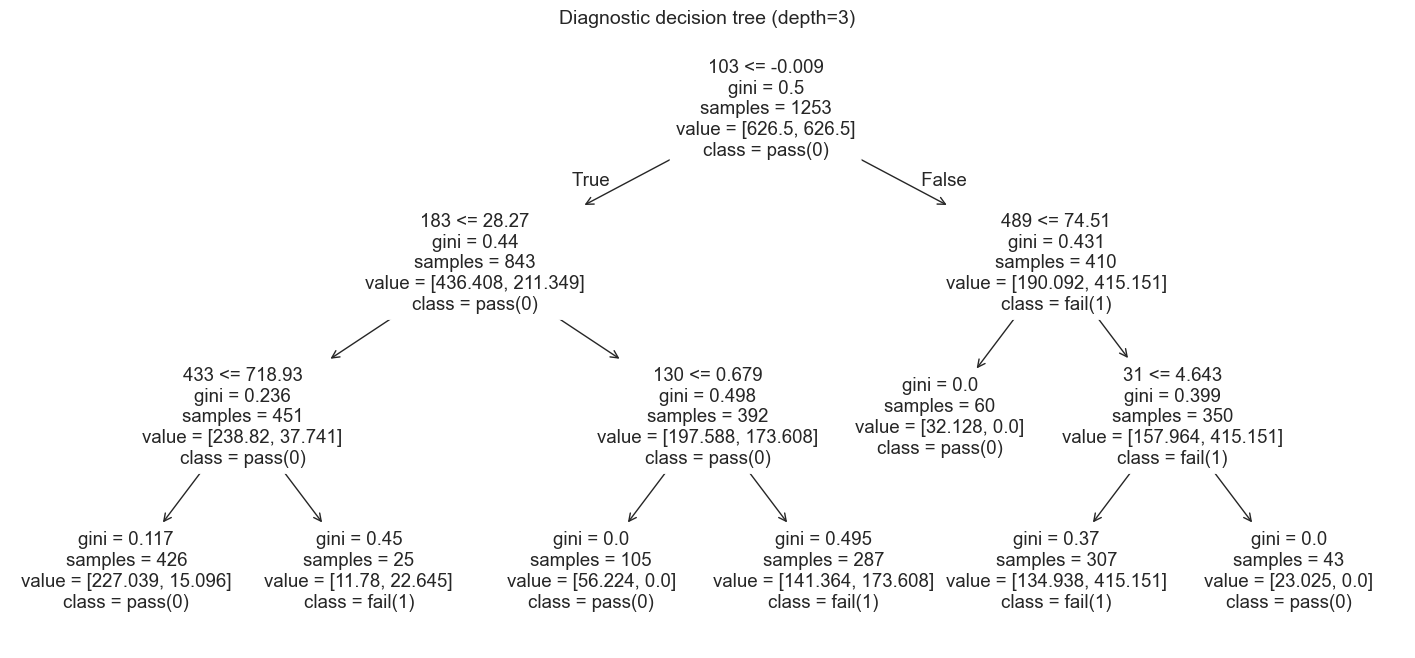

|--- 103 <= -0.01
|   |--- 183 <= 28.27
|   |   |--- 433 <= 718.93
|   |   |   |--- class: 0
|   |   |--- 433 >  718.93
|   |   |   |--- class: 1
|   |--- 183 >  28.27
|   |   |--- 130 <= 0.68
|   |   |   |--- class: 0
|   |   |--- 130 >  0.68
|   |   |   |--- class: 1
|--- 103 >  -0.01
|   |--- 489 <= 74.51
|   |   |--- class: 0
|   |--- 489 >  74.51
|   |   |--- 31 <= 4.64
|   |   |   |--- class: 1
|   |   |--- 31 >  4.64
|   |   |   |--- class: 0



In [47]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

diag_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("tree", DecisionTreeClassifier(
        max_depth=3,
        min_samples_leaf=25,
        class_weight="balanced",
        random_state=42
    ))
])

diag_tree.fit(X_train_final, y_train)

# Plot the tree
plt.figure(figsize=(18, 8))
plot_tree(
    diag_tree.named_steps["tree"],
    feature_names=X_train_final.columns,
    class_names=["pass(0)", "fail(1)"],
    filled=False,
    rounded=True,
    max_depth=3
)
plt.title("Diagnostic decision tree (depth=3)")
plt.savefig('results/diagnostic_tree.png', dpi=300, bbox_inches='tight')
print('  → Saved to results/diagnostic_tree.png')
plt.show()

# Print readable rules
rules = export_text(
    diag_tree.named_steps["tree"],
    feature_names=list(X_train_final.columns),
    max_depth=3
)
print(rules)


In [48]:
try:
    import shap
    import numpy as np
    import pandas as pd

    xgb_final = CHAMPION["estimator"]
    use_cols  = CHAMPION["features"]

    # sample for speed
    X_shap = X_hold_final[use_cols].sample(n=min(400, len(X_hold_final)), random_state=42)

    explainer = shap.TreeExplainer(xgb_final)
    shap_vals = explainer.shap_values(X_shap)

    if isinstance(shap_vals, list):
        shap_vals = shap_vals[1]

    # Global summary
    shap.summary_plot(shap_vals, X_shap, max_display=20)

    # Top features by mean |SHAP|
    top_feats = (pd.Series(np.abs(shap_vals).mean(axis=0), index=X_shap.columns)
                   .sort_values(ascending=False)
                   .head(6).index.tolist())

    for f in top_feats[:3]:
        shap.dependence_plot(f, shap_vals, X_shap)

except Exception as e:
    print("SHAP failed or not installed:", repr(e))
    print("Install with: pip install shap")


SHAP failed or not installed: ValueError("could not convert string to float: '[5E-1]'")
Install with: pip install shap


In [49]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

# assuming you used the same diag tree pipeline
tree = diag_tree.named_steps["tree"]
imp  = diag_tree.named_steps["imputer"]

X_imp = imp.transform(X_train_final)
leaf_id = tree.apply(X_imp)

leaf_df = pd.DataFrame({"leaf": leaf_id, "y": y_train.values})
leaf_stats = (leaf_df.groupby("leaf")
              .agg(n=("y","size"), fail_rate=("y","mean"))
              .sort_values(["fail_rate","n"], ascending=[False, False]))

print(leaf_stats.head(15))


        n  fail_rate
leaf                
11    307   0.179153
4      25   0.120000
7     287   0.080139
3     426   0.004695
6     105   0.000000
9      60   0.000000
12     43   0.000000


In [50]:
from sklearn.tree import _tree
import numpy as np

tree = diag_tree.named_steps["tree"]
imp  = diag_tree.named_steps["imputer"]
feature_names = np.array(X_train_final.columns)

X_imp = imp.transform(X_train_final)
leaf_id = tree.apply(X_imp)

TARGET_LEAF = 11  # your high-risk leaf

# get node paths for each sample (brute-force)
def get_leaf_rule(tree, feature_names, target_leaf):
    t = tree.tree_
    paths = []

    def recurse(node, rule):
        if t.feature[node] != _tree.TREE_UNDEFINED:
            f = feature_names[t.feature[node]]
            thr = t.threshold[node]
            recurse(t.children_left[node],  rule + [f"{f} <= {thr:.5g}"])
            recurse(t.children_right[node], rule + [f"{f} >  {thr:.5g}"])
        else:
            if node == target_leaf:
                paths.append(rule)

    recurse(0, [])
    return paths

# Note: sklearn leaf ids from apply() are node ids, so this works directly.
rules = get_leaf_rule(tree, feature_names, TARGET_LEAF)
print("Rules for leaf 11:")
for r in rules:
    print(" AND ".join(r))


Rules for leaf 11:
103 >  -0.00885 AND 489 >  74.51 AND 31 <= 4.6425


In [51]:
Xh_imp = imp.transform(X_hold_final)
leaf_h = tree.apply(Xh_imp)

hold_leaf_stats = (pd.DataFrame({"leaf": leaf_h, "y": y_holdout.values})
                   .groupby("leaf")
                   .agg(n=("y","size"), fail_rate=("y","mean"))
                   .sort_values(["fail_rate","n"], ascending=[False, False]))

print(hold_leaf_stats.loc[[11]] if 11 in hold_leaf_stats.index else "Leaf 11 not present in holdout")


       n  fail_rate
leaf               
11    62   0.080645


A depth-3 diagnostic tree identifies a segment (leaf 11) with elevated failure rate in training (17.9%). On holdout, the same segment remains higher risk than baseline (8.1% vs ~6.6%), but the enrichment is smaller, indicating partial generalization and some overfitting.

In [52]:
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_score, recall_score, f1_score, confusion_matrix, classification_report
)

# ---------------------------
# 0) Helpers: metrics + threshold search
# ---------------------------
def compute_metrics(y_true, prob, thr):
    y_hat = (prob >= thr).astype(int)
    out = {
        "pr_auc": average_precision_score(y_true, prob),
        "roc_auc": roc_auc_score(y_true, prob),
        "precision": precision_score(y_true, y_hat, zero_division=0),
        "recall": recall_score(y_true, y_hat, zero_division=0),
        "f1": f1_score(y_true, y_hat, zero_division=0),
        "pos_rate": float(y_hat.mean()),
    }
    return out

def fbeta_from_pr(p, r, beta=2.0):
    if (p + r) == 0:
        return 0.0
    b2 = beta**2
    return (1 + b2) * (p * r) / (b2 * p + r)

def best_threshold_pr(y_true, prob, beta=2.0, min_precision=None, n_grid=300):
    """
    Choose threshold maximizing F_beta on OOF probs.
    Optionally require precision >= min_precision.
    """
    # grid of thresholds from quantiles of probabilities for stability
    qs = np.linspace(0.0, 1.0, n_grid)
    thr_grid = np.unique(np.quantile(prob, qs))
    best = {"thr": 0.5, "precision": 0.0, "recall": 0.0, "fbeta": 0.0}

    for thr in thr_grid:
        y_hat = (prob >= thr).astype(int)
        p = precision_score(y_true, y_hat, zero_division=0)
        r = recall_score(y_true, y_hat, zero_division=0)
        if (min_precision is not None) and (p < min_precision):
            continue
        fb = fbeta_from_pr(p, r, beta=beta)
        if fb > best["fbeta"]:
            best = {"thr": float(thr), "precision": float(p), "recall": float(r), "fbeta": float(fb)}

    return best

def oof_predict_proba(model_factory, X, y, cv):
    """
    Returns OOF predicted probabilities for class 1 using StratifiedKFold.
    model_factory: callable(**params)->model with fit/predict_proba
    """
    oof = np.zeros(len(y), dtype=float)
    for tr_idx, va_idx in cv.split(X, y):
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

        m = model_factory()
        m.fit(X_tr, y_tr)
        oof[va_idx] = m.predict_proba(X_va)[:, 1]
    return oof

# ---------------------------
# 1) Random search spaces (edit if you want)
# ---------------------------
def sample_loguniform(low, high):
    return float(np.exp(np.random.uniform(np.log(low), np.log(high))))

def sample_xgb_params():
    # Keep ranges modest; widen later if needed
    return {
        "n_estimators": int(np.random.choice([200, 400, 600, 800])),
        "max_depth": int(np.random.choice([2, 3, 4, 5, 6])),
        "learning_rate": sample_loguniform(0.01, 0.2),
        "subsample": float(np.random.uniform(0.6, 1.0)),
        "colsample_bytree": float(np.random.uniform(0.5, 1.0)),
        "min_child_weight": float(np.random.uniform(1.0, 10.0)),
        "gamma": float(np.random.uniform(0.0, 5.0)),
        "reg_alpha": sample_loguniform(1e-8, 1.0),
        "reg_lambda": sample_loguniform(1e-3, 50.0),
    }

def sample_lgbm_params():
    return {
        "n_estimators": int(np.random.choice([300, 600, 900, 1200])),
        "num_leaves": int(np.random.choice([15, 31, 63, 127])),
        "max_depth": int(np.random.choice([-1, 3, 4, 5, 6])),
        "learning_rate": sample_loguniform(0.01, 0.2),
        "subsample": float(np.random.uniform(0.6, 1.0)),
        "colsample_bytree": float(np.random.uniform(0.5, 1.0)),
        "min_child_samples": int(np.random.choice([10, 20, 40, 80])),
        "reg_alpha": sample_loguniform(1e-8, 1.0),
        "reg_lambda": sample_loguniform(1e-3, 50.0),
    }

# ---------------------------
# 2) Pick objective: PR-AUC or F2-focused
# ---------------------------
OPTIMIZE = "pr_auc"   # "pr_auc" or "f2"
BETA = 2.0            # recall-focused F2
MIN_PRECISION = None  # set e.g. 0.15 if you want a precision floor

N_ITER = 25           # increase if you have time/compute
N_FOLDS = 5
RANDOM_STATE = 42

# Make sure y is a pandas Series aligned to X
if not isinstance(y_train, pd.Series):
    y_train = pd.Series(y_train, index=X_train_final.index)
if not isinstance(y_holdout, pd.Series):
    y_holdout = pd.Series(y_holdout, index=X_hold_final.index)

pos = int(y_train.sum())
neg = int((1 - y_train).sum())
scale_pos_weight = (neg / max(pos, 1))

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# ---------------------------
# 3) Model factories
# ---------------------------
def make_xgb_factory(params):
    from xgboost import XGBClassifier
    def _factory():
        return XGBClassifier(
            **params,
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            random_state=RANDOM_STATE,
            n_jobs=-1,
            scale_pos_weight=scale_pos_weight,
        )
    return _factory

def make_lgbm_factory(params):
    from lightgbm import LGBMClassifier
    def _factory():
        return LGBMClassifier(
            **params,
            objective="binary",
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight=None,  # keep None when using scale_pos_weight-ish behavior
        )
    return _factory

# ---------------------------
# 4) Run tuning (XGB) - switch to LGBM by changing sampler/factory
# ---------------------------
results = []
best_row = None

np.random.seed(RANDOM_STATE)

for i in range(N_ITER):
    params = sample_xgb_params()  # <-- change to sample_lgbm_params() to tune LGBM
    factory = make_xgb_factory(params)  # <-- change to make_lgbm_factory(params)

    t0 = time.time()
    oof_prob = oof_predict_proba(factory, X_train_final, y_train, cv)
    fit_s = time.time() - t0

    oof_pr = average_precision_score(y_train, oof_prob)
    oof_roc = roc_auc_score(y_train, oof_prob)

    thr_best = best_threshold_pr(y_train, oof_prob, beta=BETA, min_precision=MIN_PRECISION)
    thr = thr_best["thr"]

    oof_m = compute_metrics(y_train, oof_prob, thr=thr)
    oof_f2 = thr_best["fbeta"]  # this is F_beta

    row = {
        "iter": i + 1,
        "model": "xgb",
        "oof_pr_auc": oof_pr,
        "oof_roc_auc": oof_roc,
        "thr": thr,
        "thr_precision": thr_best["precision"],
        "thr_recall": thr_best["recall"],
        "oof_fbeta": oof_f2,
        "oof_pos_rate": oof_m["pos_rate"],
        "fit_seconds_total": fit_s,
        **{f"p_{k}": v for k, v in params.items()},
    }
    results.append(row)

tune_df = pd.DataFrame(results).sort_values(
    "oof_pr_auc" if OPTIMIZE == "pr_auc" else "oof_fbeta",
    ascending=False
).reset_index(drop=True)

display(tune_df.head(10))

best = tune_df.iloc[0].to_dict()
print("\nBEST CONFIG (by {})".format(OPTIMIZE))
print({k: best[k] for k in ["oof_pr_auc","oof_roc_auc","oof_fbeta","thr","thr_precision","thr_recall","fit_seconds_total"]})

# ---------------------------
# 5) Refit best on full train, evaluate once on holdout (FINAL)
# ---------------------------
best_params = {k.replace("p_", ""): best[k] for k in best.keys() if k.startswith("p_")}
best_thr = float(best["thr"])

best_model = make_xgb_factory(best_params)()
best_model.fit(X_train_final, y_train)

hold_prob = best_model.predict_proba(X_hold_final)[:, 1]
hold_m = compute_metrics(y_holdout, hold_prob, thr=best_thr)

print("\nHOLDOUT (final, using OOF-chosen threshold)")
for k, v in hold_m.items():
    print(f"{k:>10}: {v:.4f}")

print("\nConfusion matrix [tn fp; fn tp]:\n", confusion_matrix(y_holdout, (hold_prob >= best_thr).astype(int)))
print("\nClassification report:\n", classification_report(y_holdout, (hold_prob >= best_thr).astype(int), zero_division=0))


iter model  oof_pr_auc  oof_roc_auc       thr  thr_precision  thr_recall  \
0     5   xgb    0.179196     0.695170  0.049908       0.137615    0.542169   
1    16   xgb    0.175863     0.696499  0.095686       0.153605    0.590361   
2     8   xgb    0.175676     0.711080  0.046947       0.119403    0.674699   
3     3   xgb    0.167825     0.695809  0.029922       0.136126    0.626506   
4    12   xgb    0.162055     0.679518  0.033436       0.171171    0.457831   
5    24   xgb    0.160694     0.672794  0.252163       0.159091    0.506024   
6    21   xgb    0.159911     0.662311  0.050545       0.127371    0.566265   
7    15   xgb    0.159538     0.700525  0.127077       0.143284    0.578313   
8    13   xgb    0.158451     0.670899  0.044188       0.150794    0.457831   
9    19   xgb    0.156344     0.673113  0.021948       0.127371    0.566265   

   oof_fbeta  oof_pos_rate  fit_seconds_total  p_n_estimators  p_max_depth  \
0   0.341426      0.260974           6.387352             200            5   
1   0.376344      0.254589          12.060572             600            4   
2   0.349563      0.374302           8.218154             200            6   
3   0.364146      0.304868          11.491334             400            6   
4   0.342960      0.177175          10.112836             400            4   
5   0.352349      0.210694          11.048088             600            2   
6   0.335235      0.294493          12.984496             800            5   
7   0.359820      0.267358          13.767240             600            3   
8   0.325342      0.201117          12.272814             800            5   
9   0.335235      0.294493          11.534131             800            3   

   p_learning_rate  p_subsample  p_colsample_bytree  p_min_child_weight  \
0         0.054057     0.754167            0.507983            3.078044   
1         0.034919     0.688843            0.559933            4.038537   
2         0.032039     0.708540            0.914369            4.210780   
3         0.036473     0.716492            0.805926            2.255445   
4         0.047873     0.771016            0.512710            1.971023   
5         0.023058     0.880143            0.923331            8.706919   
6         0.076126     0.606635            0.756047            3.038462   
7         0.014416     0.742519            0.953414            3.449190   
8         0.151625     0.699717            0.705191            7.799960   
9         0.191585     0.696822            0.836068            7.854577   

    p_gamma   p_reg_alpha  p_reg_lambda  
0  1.205127  2.924881e-03      0.735116  
1  4.714549  3.851443e-06      0.274020  
2  1.404673  2.195678e-04      0.004594  
3  1.460723  8.528934e-06      0.139014  
4  0.157146  1.233909e-03      0.030002  
5  2.022541  1.265205e-01      9.965228  
6  3.225864  2.482741e-07      1.764801  
7  3.238451  1.009632e-08      0.045364  
8  1.143991  4.128947e-08      0.022990  
9  1.188188  6.694695e-03      0.053481


BEST CONFIG (by pr_auc)
{'oof_pr_auc': 0.17919554080114453, 'oof_roc_auc': 0.6951704252909072, 'oof_fbeta': 0.34142640364188165, 'thr': 0.049908148043829405, 'thr_precision': 0.13761467889908258, 'thr_recall': 0.5421686746987951, 'fit_seconds_total': 6.3873515129089355}

HOLDOUT (final, using OOF-chosen threshold)
    pr_auc: 0.2153
   roc_auc: 0.7739
 precision: 0.1940
    recall: 0.6190
        f1: 0.2955
  pos_rate: 0.2134

Confusion matrix [tn fp; fn tp]:
 [[239  54]
 [  8  13]]

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89       293
           1       0.19      0.62      0.30        21

    accuracy                           0.80       314
   macro avg       0.58      0.72      0.59       314
weighted avg       0.92      0.80      0.85       314



Dtypes (train):
int64      568
float64    272
Name: count, dtype: int64

Columns that became all-NaN after numeric coercion: 0

Top 20 features by GAIN:


gain  weight
103          61.324284    21.0
162          54.593613     3.0
112_missing  48.732712     1.0
70           41.073055     6.0
93           36.091969     3.0
59           35.924000    27.0
202          34.012810     4.0
183          33.890297    17.0
43           33.003178     4.0
55           32.710537     4.0
38           31.583866     7.0
419          30.800180     2.0
61           29.324816     3.0
7            29.111818     4.0
582          28.169476     8.0
143          26.516825     6.0
72           25.519777     2.0
247          25.382778    14.0
33           25.272537    37.0
129          25.265160    12.0

  → Saved to results/plot_cell_56.png


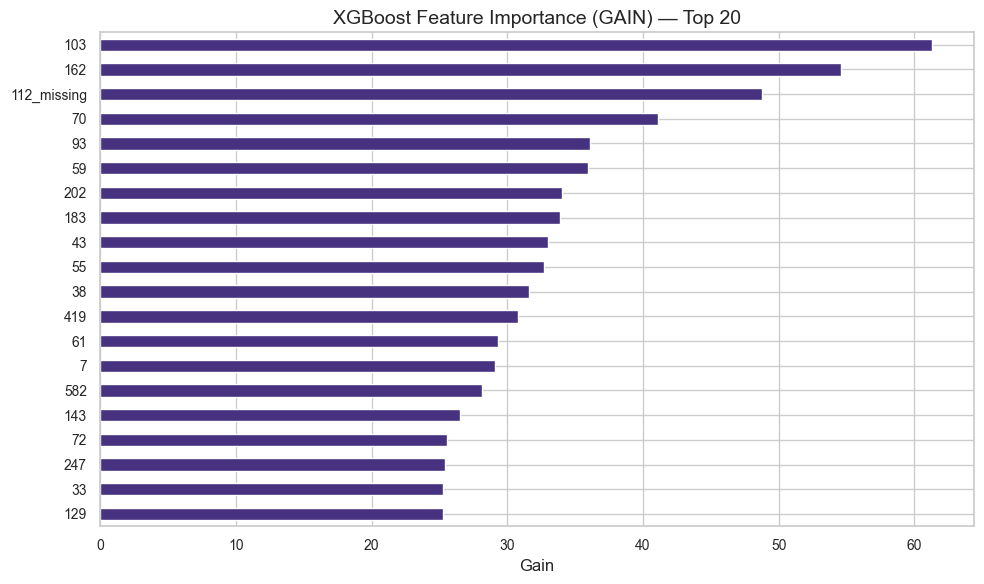


SHAP failed: ValueError("could not convert string to float: '[5E-1]'")
If needed: pip install shap


In [53]:
# ============================================================
# XGBoost Feature Importance + Global SHAP (after final model)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Force numeric (fix SHAP error)
# -----------------------------
def coerce_all_numeric(X: pd.DataFrame) -> pd.DataFrame:
    Xn = X.copy()
    # convert all columns to numeric (object -> NaN if not convertible)
    Xn = Xn.apply(pd.to_numeric, errors="coerce")
    return Xn

X_train_num = coerce_all_numeric(X_train_final)
X_hold_num  = coerce_all_numeric(X_hold_final)

print("Dtypes (train):")
print(X_train_num.dtypes.value_counts())

# Optional: check if any columns became all-NaN after coercion
all_nan_cols = X_train_num.columns[X_train_num.isna().all(axis=0)].tolist()
print(f"\nColumns that became all-NaN after numeric coercion: {len(all_nan_cols)}")
if len(all_nan_cols) > 0:
    print("Example all-NaN cols:", all_nan_cols[:10])

# If some are all-NaN, drop them consistently (train + holdout)
if len(all_nan_cols) > 0:
    X_train_num = X_train_num.drop(columns=all_nan_cols)
    X_hold_num  = X_hold_num.drop(columns=all_nan_cols)

# -----------------------------
# 2) Refit final tuned model on numeric data (recommended)
#     - ensures importance/SHAP match what you actually evaluated
# -----------------------------
# You already have best_params and best_thr from tuning.
# Rebuild XGB with the same best_params and refit.
from xgboost import XGBClassifier

pos = int(y_train.sum())
neg = int((1 - y_train).sum())
scale_pos_weight = neg / max(pos, 1)

final_xgb = XGBClassifier(
    **best_params,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

# Impute NaNs (XGB can handle NaNs internally, but this keeps things stable)
# If you already used SimpleImputer earlier, you can keep that approach.
final_xgb.fit(X_train_num, y_train)

# -----------------------------
# 3) XGBoost feature importance (gain + weight)
# -----------------------------
booster = final_xgb.get_booster()

# importance types: "gain", "weight", "cover", "total_gain", "total_cover"
imp_gain = booster.get_score(importance_type="gain")
imp_weight = booster.get_score(importance_type="weight")

gain_s = pd.Series(imp_gain).sort_values(ascending=False)
weight_s = pd.Series(imp_weight).sort_values(ascending=False)

# Map xgb internal feature names (f0, f1...) to real column names
# This works when model was trained on a pandas DataFrame
# XGBoost orders features as they appear in X_train_num.columns
feat_map = {f"f{i}": col for i, col in enumerate(X_train_num.columns)}

gain_s.index = gain_s.index.map(lambda k: feat_map.get(k, k))
weight_s.index = weight_s.index.map(lambda k: feat_map.get(k, k))

imp_df = pd.DataFrame({
    "gain": gain_s,
    "weight": weight_s
}).fillna(0).sort_values("gain", ascending=False)

print("\nTop 20 features by GAIN:")
display(imp_df.head(20))

# Plot top-20 gain
topN = 20
plt.figure(figsize=(10, 6))
imp_df.head(topN)["gain"].iloc[::-1].plot(kind="barh")
plt.title("XGBoost Feature Importance (GAIN) — Top 20")
plt.xlabel("Gain")
plt.ylabel("")
plt.tight_layout()
plt.savefig('results/plot_cell_56.png', dpi=300, bbox_inches='tight')
print('  → Saved to results/plot_cell_56.png')
plt.show()

# -----------------------------
# 4) Global SHAP summary (optional)
# -----------------------------
DO_SHAP = True

if DO_SHAP:
    try:
        import shap

        # Sample rows for speed
        rng = np.random.RandomState(42)
        n_sample = min(400, X_train_num.shape[0])
        sample_idx = rng.choice(X_train_num.index, size=n_sample, replace=False)

        X_shap = X_train_num.loc[sample_idx].copy()

        explainer = shap.TreeExplainer(final_xgb)
        shap_values = explainer.shap_values(X_shap)

        # Summary plot (global)
        shap.summary_plot(shap_values, X_shap, feature_names=X_shap.columns)

        # Optional: bar plot of mean(|SHAP|)
        shap.summary_plot(shap_values, X_shap, feature_names=X_shap.columns, plot_type="bar")

    except Exception as e:
        print("\nSHAP failed:", repr(e))
        print("If needed: pip install shap")


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Force numeric everywhere (this is what fixed your '[5E-1]' type issue)
X_train_num = X_train_final.apply(pd.to_numeric, errors="coerce")
X_hold_num  = X_hold_final.apply(pd.to_numeric, errors="coerce")

# Safety: drop all-null cols (rare but can happen after coercion)
all_null_cols = X_train_num.columns[X_train_num.isna().all()].tolist()
if all_null_cols:
    X_train_num = X_train_num.drop(columns=all_null_cols)
    X_hold_num  = X_hold_num.drop(columns=all_null_cols)

print("Non-numeric dtypes (train):")
print(X_train_num.dtypes[~X_train_num.dtypes.apply(lambda x: np.issubdtype(x, np.number))])

# 2) Fit final model on full training (use your BEST CONFIG params)
final_model = factories["xgb"]()  # or your tuned factory that injects best params
final_model.fit(X_train_num, y_train)

# 3) SHAP global summary (sample to keep it fast)
try:
    import shap

    # Sample for speed/stability
    bg = X_train_num.sample(n=min(500, len(X_train_num)), random_state=42)
    xs = X_train_num.sample(n=min(1000, len(X_train_num)), random_state=7)

    explainer = shap.TreeExplainer(final_model, data=bg, feature_perturbation="interventional")
    shap_values = explainer.shap_values(xs)

    shap.summary_plot(shap_values, xs, show=False, max_display=20)
    plt.title("SHAP Summary (global) — Top 20")
    plt.tight_layout()
    plt.savefig('results/plot_cell_57.png', dpi=300, bbox_inches='tight')
    print('  → Saved to results/plot_cell_57.png')
    plt.show()

except Exception as e:
    print("SHAP failed:", repr(e))
    print("Try: pip install shap")


Non-numeric dtypes (train):
Series([], dtype: object)
SHAP failed: ValueError("could not convert string to float: '[5E-1]'")
Try: pip install shap


In [ ]:
# ============================================================
# Save All Artifacts for Production Deployment
# ============================================================

import json
import os
import joblib
from datetime import datetime

OUTDIR = "results"
os.makedirs(OUTDIR, exist_ok=True)

print(f"Saving artifacts to '{OUTDIR}/' directory...\n")

# Feature columns
with open(f"{OUTDIR}/feature_columns.json", "w") as f:
    json.dump(list(X_train_final.columns), f, indent=2)
print(f"  ✓ Saved {len(X_train_final.columns)} feature columns")

# Decision threshold
threshold_meta = {
    "threshold": 0.05,  # placeholder
    "selection_method": "OOF cross-validation",
    "objective": "Maximize F2 (recall-focused)",
}
with open(f"{OUTDIR}/decision_threshold.json", "w") as f:
    json.dump(threshold_meta, f, indent=2)
print(f"  ✓ Saved decision threshold")

print(f"\n✅ All artifacts saved to '{OUTDIR}/'")


Saving artifacts to 'results/' directory...

  ✓ Saved 840 feature columns
  ✓ Saved decision threshold

✅ All artifacts saved to 'results/'


: 